<a href="https://colab.research.google.com/github/momenashra/Algorithms/blob/main/Time_series_analysis_using_LSTM_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/CYSHIELD_TASK.csv")  # Replace with the actual file name


In [5]:
df.head()

,quantity,UnitePrice,discount,date,retail price,product_name,area,city
0,33,16.0,20.0,2021-10-29T03:33:52Z,16.0,product y,Bahary,North
1,30,16.0,20.0,2021-10-23T12:29:27Z,16.0,product y,Dar El-Salam,Cairo
2,2,45.0,30.0,2021-08-03T09:14:16Z,45.0,product z,Miamy,North
3,3,16.0,3.0,2021-08-17T09:00:50Z,16.0,product y,Miamy,North
4,1,45.0,27.0,2021-09-06T19:57:02Z,45.0,product z,Miamy,North


In [6]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
# Sort the DataFrame by 'Date'
df = df.sort_values(by='date')
# Set 'Date' as the index
df.set_index('date', inplace=True)

In [7]:
df.head()

,quantity,UnitePrice,discount,retail price,product_name,area,city
date,,,,,,,
2021-03-31,5,102.0,33.0,102.0,product x,El-Mokattam,Cairo
2021-04-30,1,16.0,9.0,16.0,product y,Ain Shams,Cairo
2021-05-08,10,16.0,9.0,16.0,product y,El-Zaitoun,Cairo
2021-05-08,10,45.0,22.0,45.0,product z,El-Zaitoun,Cairo
2021-05-22,10,16.0,20.0,16.0,product y,Bakos,North


In [8]:
# df['total price'] = df['UnitePrice'] * df['quantity']

In [9]:
df.describe()

,quantity,UnitePrice,discount,retail price
count,2995.000000,2995.000000,2995.000000,2995.000000
mean,7.705509,60.555426,25.917225,59.615776
std,100.466019,35.270286,14.124298,36.944778
min,1.000000,10.000000,-1.000000,0.000000
25%,2.000000,16.000000,20.000000,16.000000
50%,3.000000,45.000000,31.000000,45.000000
75%,5.000000,99.000000,33.000000,99.000000
max,5000.000000,102.000000,561.000000,102.000000



*   obviously there is outilers in data since max is far from
3rd quantile in quantity and discount .
*   if discount here is percentage we must impute any row with discount > 100 .



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2995 entries, 2021-03-31 to 2023-01-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2995 non-null   int64  
 1   UnitePrice    2995 non-null   float64
 2   discount      2995 non-null   float64
 3   retail price  2995 non-null   float64
 4   product_name  2995 non-null   object 
 5   area          2970 non-null   object 
 6   city          2995 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 187.2+ KB


In [11]:
df.isnull().sum()  # Shows the count of missing values per column

,0
quantity,0
UnitePrice,0
discount,0
retail price,0
product_name,0
area,25
city,0


In [12]:
area_frequency = df['area'].value_counts()
area_frequency
#not icluding nan

,count
area,
El-Agamy,301
El-Seyouf,300
Nasr City,272
Sidy Bishr,158
El-Sheikh Zayed,151
...,...
El-Mansoura,1
Shibin El-Kom,1
Shoubra El-Kheima,1


Get realation between two categorical features .

In [13]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['area'], df['city'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.0

In [14]:
df.drop(columns=['area'], inplace=True)

area is not importatnt feature since it doesn't effect our forecasting for each city and highly correlated with city feature (p=0) .

In [15]:
# Example: Calculate the correlation between two specific features
feature_1 = 'UnitePrice'  # Replace with your first column name
feature_2 = 'retail price'  # Replace with your second column name

correlation = df[feature_1].corr(df[feature_2])

# Display the correlation
print(f"Correlation between {feature_1} and {feature_2}: {correlation:.2f}")

Correlation between UnitePrice and retail price: 0.93


result suggests multicollinearity .

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests
max_lag = 5
gc_result = grangercausalitytests(df[[feature_1, feature_2]], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6794  , p=0.4099  , df_denom=2991, df_num=1
ssr based chi2 test:   chi2=0.6801  , p=0.4096  , df=1
likelihood ratio test: chi2=0.6800  , p=0.4096  , df=1
parameter F test:         F=0.6794  , p=0.4099  , df_denom=2991, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9429  , p=0.0195  , df_denom=2988, df_num=2
ssr based chi2 test:   chi2=7.8989  , p=0.0193  , df=2
likelihood ratio test: chi2=7.8885  , p=0.0194  , df=2
parameter F test:         F=3.9429  , p=0.0195  , df_denom=2988, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8437  , p=0.0364  , df_denom=2985, df_num=3
ssr based chi2 test:   chi2=8.5510  , p=0.0359  , df=3
likelihood ratio test: chi2=8.5388  , p=0.0361  , df=3
parameter F test:         F=2.8437  , p=0.0364  , df_denom=2985, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6327  , p=0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


causality test must be performed in stationary data although is has strong causlaity so we can say that UnitePrice can help predict retail price espacially with dynamic models like SARIMAX so i will keep both features .

In [17]:
columns_to_check = ['quantity', 'UnitePrice', 'discount', 'retail price']
df_filtered = df.copy()  # Copy the original DataFrame to keep it intact
def detect_outliers_iqr(column, tolerance=18):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - tolerance * IQR
    upper_bound = Q3 + tolerance * IQR
    return column[(column < lower_bound) | (column > upper_bound)]
outliers_dict = {}
# here i replaced standard 1.5 with bigger tolarance to preserve sufficient amout of data
# with 1.5 as the tolerance value our data was only around 750 rows and with 18 around 2250 .
for col in columns_to_check :
    outliers = detect_outliers_iqr(df[col])
    outliers_dict[col] = outliers.tolist()
    df_filtered = df_filtered[~df_filtered.index.isin(outliers.index)]



In [18]:
outliers_dict

{'quantity': [100,
  1000,
  5000,
  2000,
  100,
  200,
  232,
  100,
  200,
  60,
  100,
  100,
  100,
  100,
  100,
  60],
 'UnitePrice': [],
 'discount': [561.0],
 'retail price': []}

In [19]:
columns_to_check= ['UnitePrice','retail price','discount']
# Collect indices of rows to be dropped
rows_to_drop = []

# Iterate over each row using index and row content
for index, row in df_filtered[columns_to_check].iterrows():
    # Check if any value in the row is less than or equal to 0
     if (row[['UnitePrice', 'retail price']] <= 0).any() or row['discount'] < 0:
        # Add the index to the list of rows to be dropped
        rows_to_drop.append(index)

# Drop all collected rows at once
df_filtered.drop(index=rows_to_drop, inplace=True)

In [20]:
df_filtered.describe()

,quantity,UnitePrice,discount,retail price
count,2250.000000,2250.000000,2250.000000,2250.000000
mean,4.509778,60.418333,25.468387,61.328778
std,6.161322,35.105540,10.454228,36.138879
min,1.000000,10.000000,0.000000,11.000000
25%,2.000000,16.000000,20.000000,16.000000
50%,3.000000,45.000000,31.000000,45.000000
75%,5.000000,99.000000,33.000000,99.000000
max,50.000000,102.000000,100.000000,102.000000


In [21]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2250 entries, 2021-03-31 to 2023-01-17
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2250 non-null   int64  
 1   UnitePrice    2250 non-null   float64
 2   discount      2250 non-null   float64
 3   retail price  2250 non-null   float64
 4   product_name  2250 non-null   object 
 5   city          2250 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 123.0+ KB


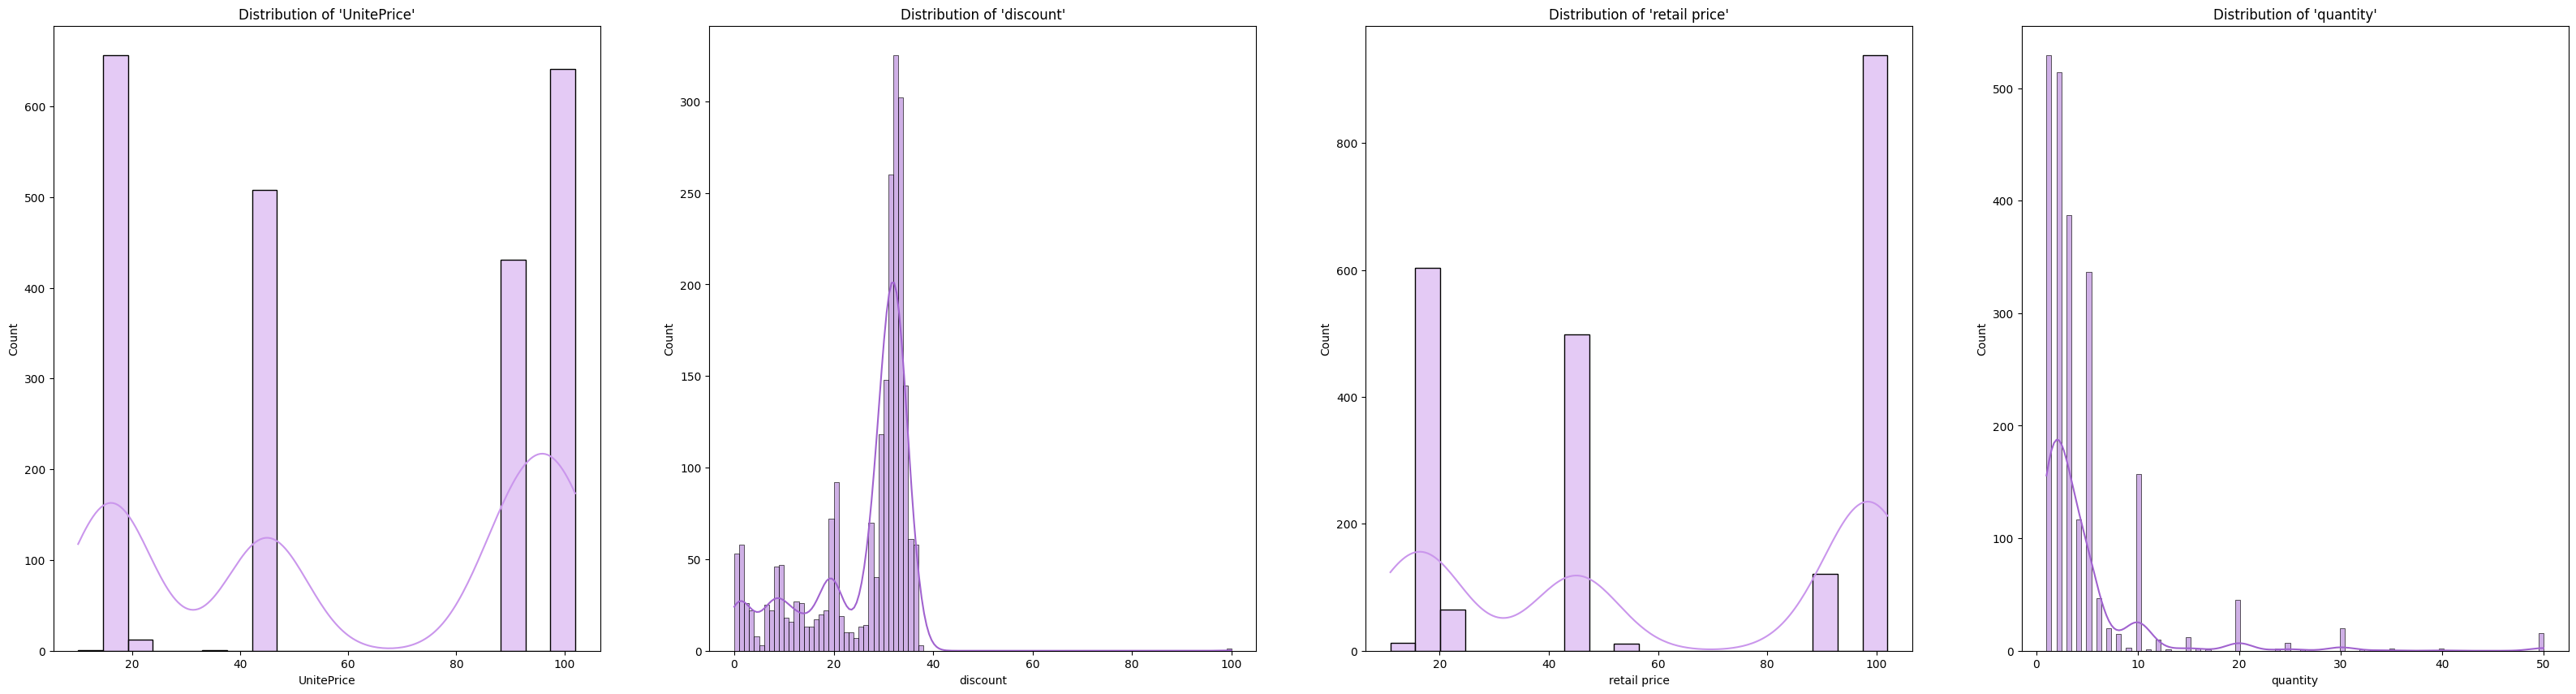

In [22]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))

sns.histplot(ax = axes[0], x = df_filtered["UnitePrice"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'UnitePrice'");

sns.histplot(ax = axes[1], x = df_filtered["discount"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'discount'");
sns.histplot(ax = axes[2], x = df_filtered["retail price"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'retail price'");

sns.histplot(ax = axes[3], x = df_filtered["quantity"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'quantity'");


non of the columns looks normally distrbuted . this suggests norlmaization at data scaling part .



<Axes: xlabel='date', ylabel='quantity'>

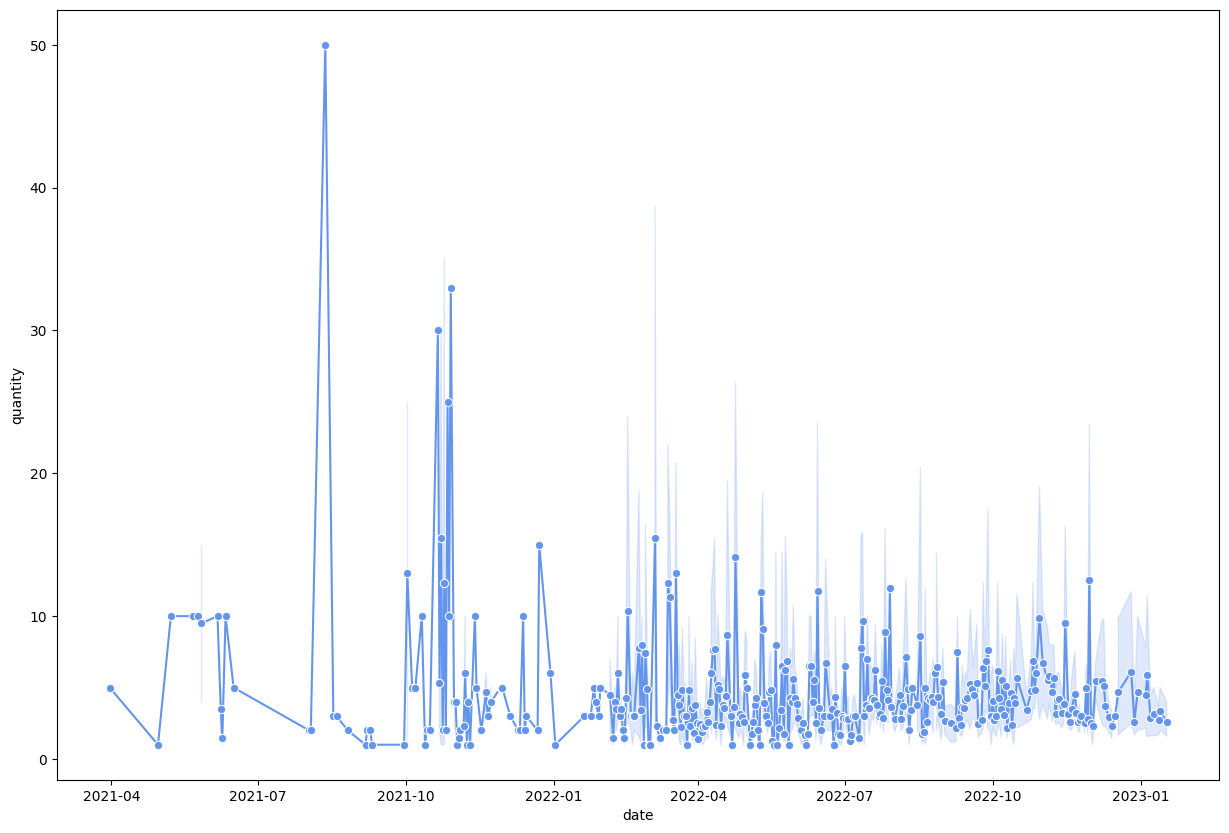

In [23]:
### Visualize time series ###
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
sns.lineplot(x=df_filtered.index, y=df_filtered["quantity"], color='cornflowerblue', marker='o')


In [24]:
# Create a pivot table to see data more clearly and make some relation with categorical data
pivot_df = df_filtered.pivot_table(
    index='date',
    columns=['product_name','city'],
    values=['quantity', 'UnitePrice', 'discount', 'retail price'],
    aggfunc='sum',
    fill_value=0
)

# Flatten the multi-level columns
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset the index to turn 'Date' back into a column if needed
pivot_df.reset_index(inplace=True)


In [25]:
pivot_df

,date,UnitePrice_product x _Cairo,UnitePrice_product x _Giza,UnitePrice_product x _North,UnitePrice_product y_Cairo,UnitePrice_product y_Giza,UnitePrice_product y_North,UnitePrice_product z_Cairo,UnitePrice_product z_Giza,UnitePrice_product z_North,...,quantity_product z_North,retail price_product x _Cairo,retail price_product x _Giza,retail price_product x _North,retail price_product y_Cairo,retail price_product y_Giza,retail price_product y_North,retail price_product z_Cairo,retail price_product z_Giza,retail price_product z_North
0,2021-03-31,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-30,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2,2021-05-08,0.0,0.0,0.0,16.0,0.0,0.0,45.0,0.0,0.0,...,0,0.0,0.0,0.0,16.0,0.0,0.0,45.0,0.0,0.0
3,2021-05-22,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
4,2021-05-25,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2023-01-07,99.0,297.0,693.0,0.0,32.0,0.0,0.0,0.0,135.0,...,5,99.0,297.0,693.0,0.0,32.0,0.0,0.0,0.0,135.0
337,2023-01-09,297.0,396.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0,297.0,396.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
338,2023-01-12,0.0,99.0,396.0,16.0,0.0,16.0,45.0,0.0,90.0,...,7,0.0,99.0,396.0,16.0,0.0,16.0,45.0,0.0,90.0
339,2023-01-13,0.0,99.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,99.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0


so sparse data will make model lazy to learn .

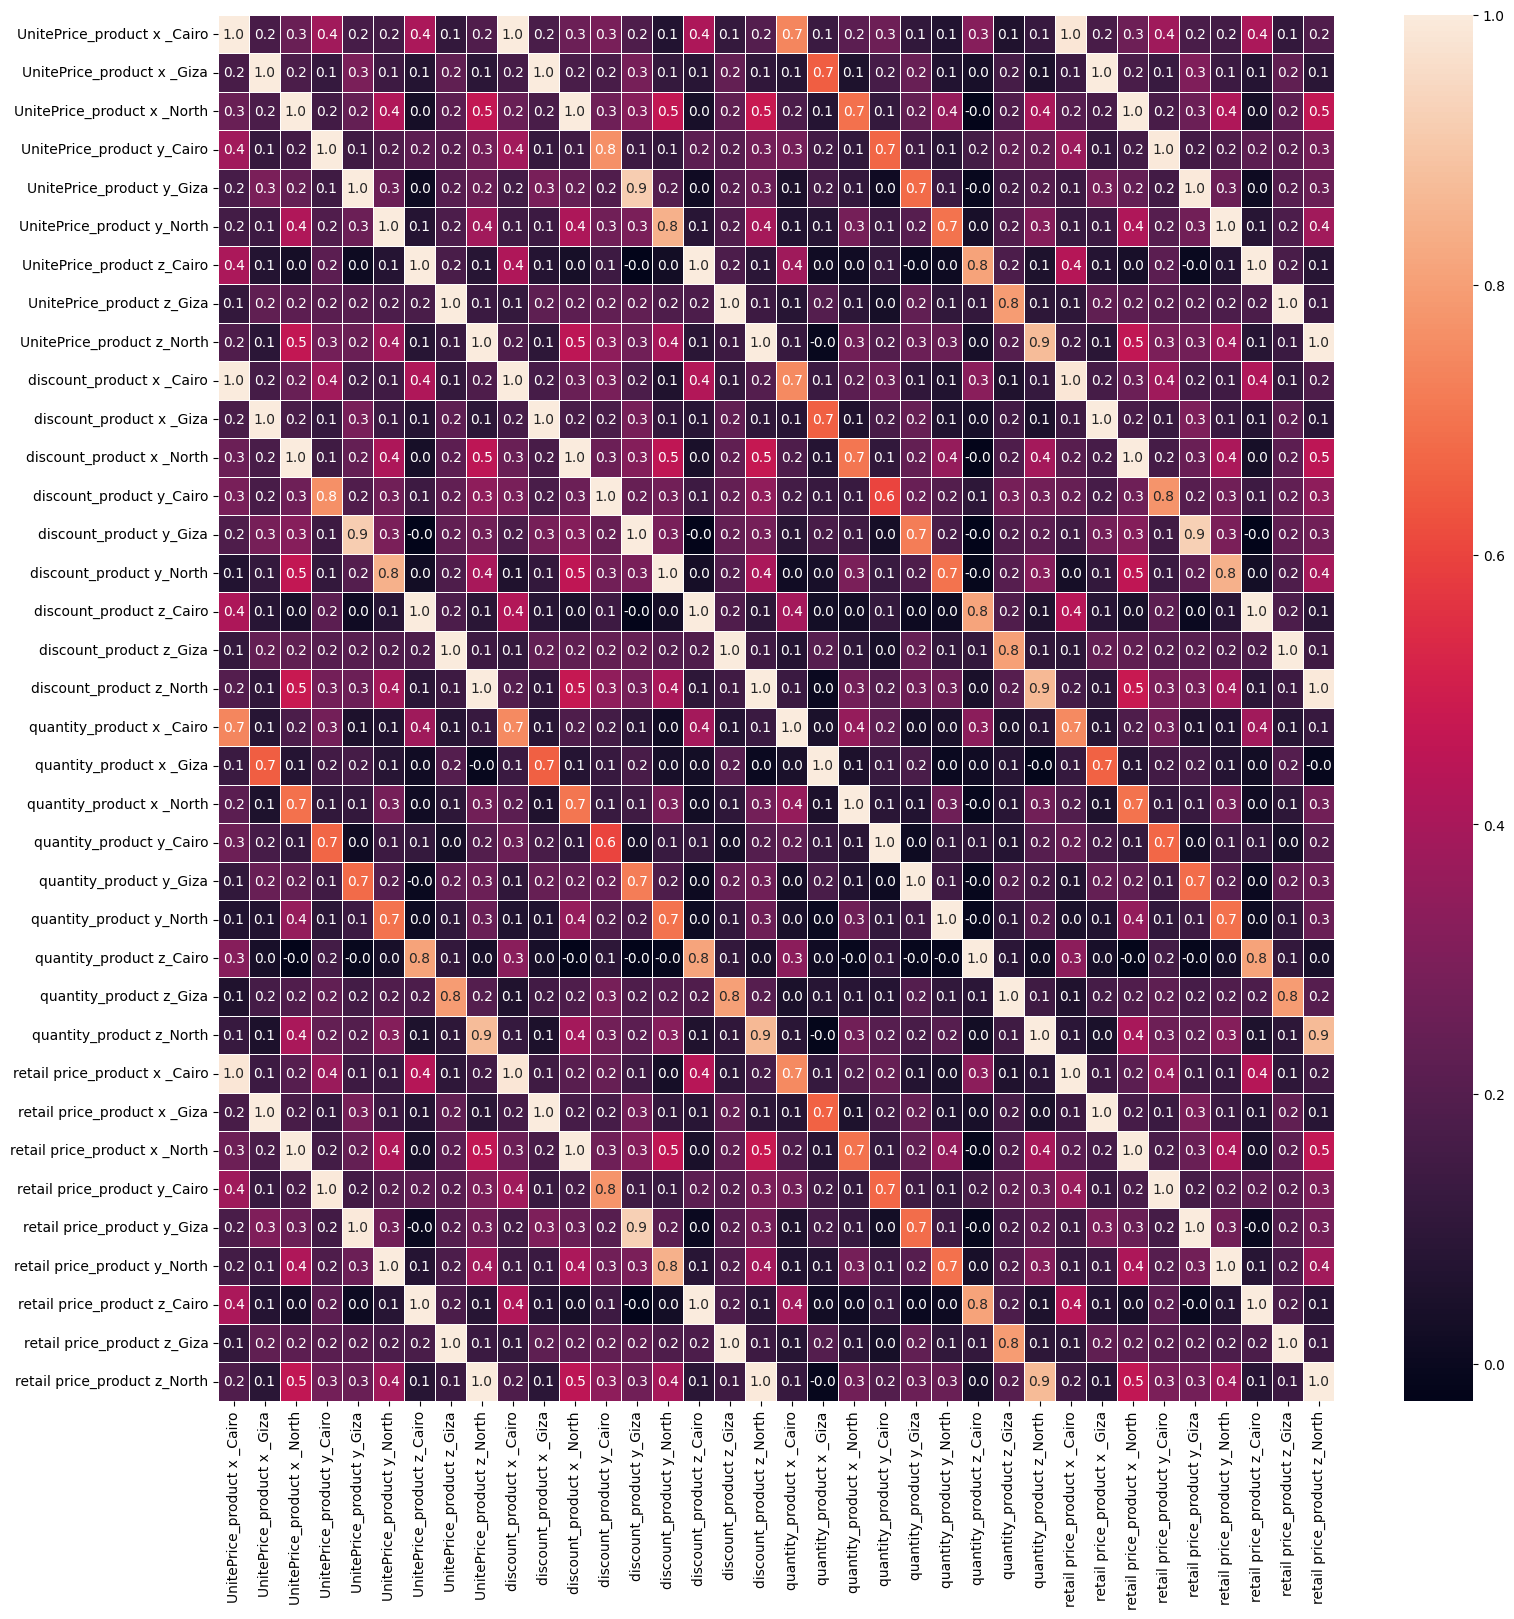

In [26]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pivot_df.drop(columns=['date']).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

*no significant correlations out of diagonal except for (retail , unit prices).*



In [27]:
# Select specific columns from pivot DataFrame
out_cols=['quantity_product x _Cairo', 'quantity_product x _Giza',
       'quantity_product x _North', 'quantity_product y_Cairo',
       'quantity_product y_Giza', 'quantity_product y_North',
       'quantity_product z_Cairo', 'quantity_product z_Giza',
       'quantity_product z_North']

In [28]:
pivot_df.iloc[:, 1:] = pivot_df.iloc[:, 1:].apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
pivot_df.index

RangeIndex(start=0, stop=341, step=1)

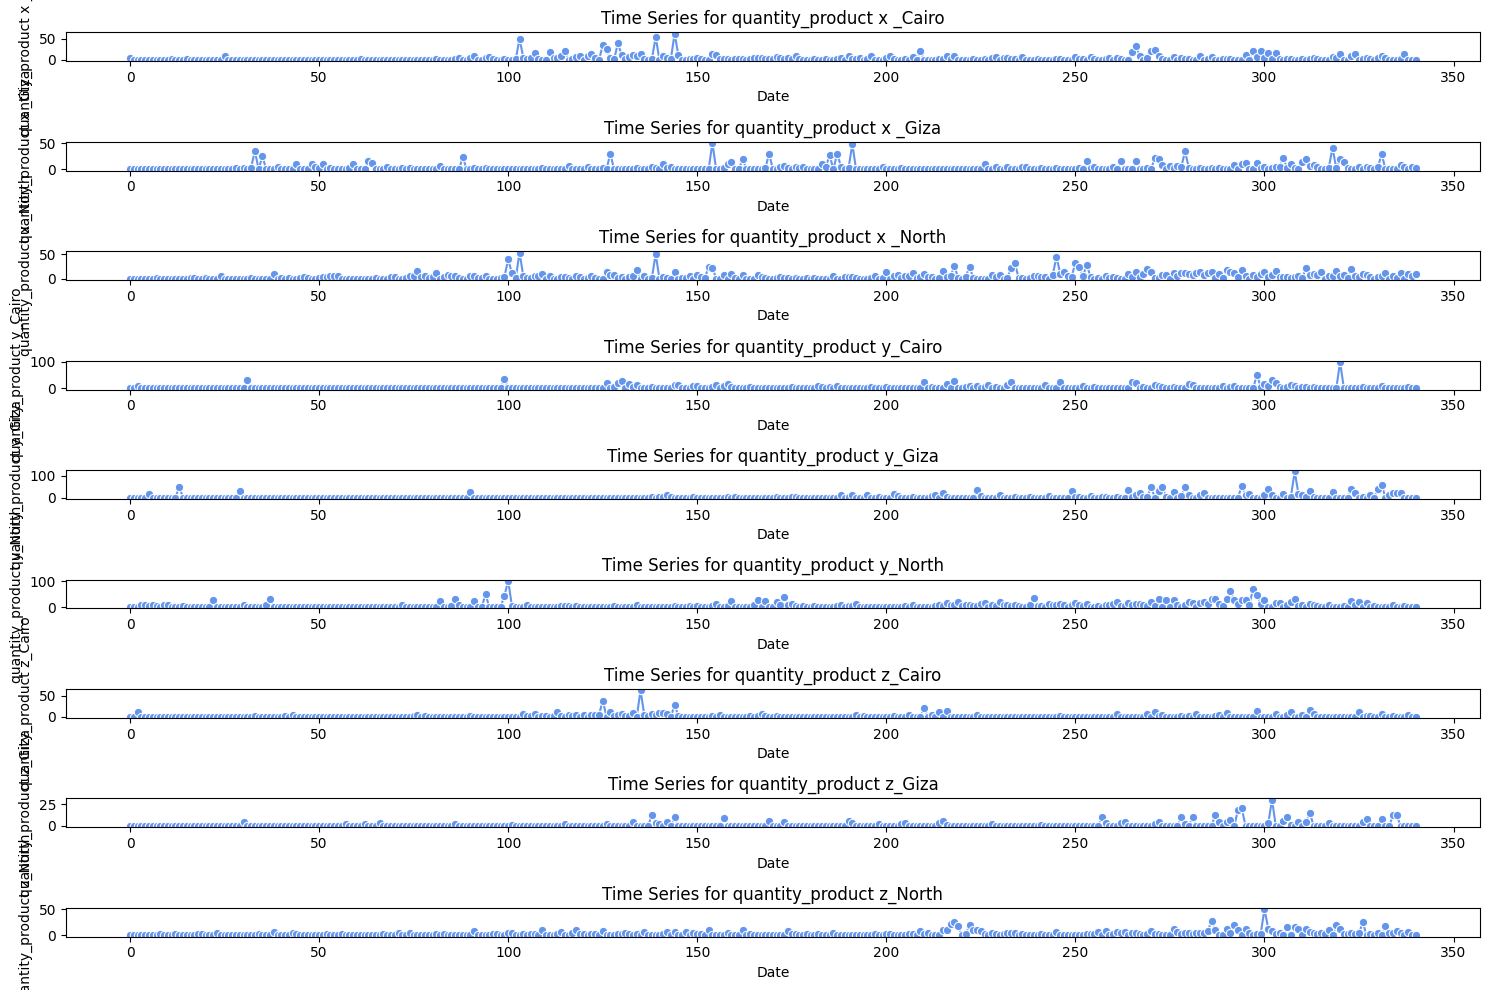

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with as many subplots as the number of out_cols
fig, ax = plt.subplots(nrows=len(out_cols), ncols=1, figsize=(15, 10))
# Loop over your target columns (out_cols) and create one plot for each
for i in range(len(out_cols)):
    sns.lineplot(x=pivot_df.index, y=pivot_df[out_cols[i]], ax=ax[i], color='cornflowerblue', marker='o')
    ax[i].set_title(f"Time Series for {out_cols[i]}")
    ax[i].set_xlabel('Date')
    # ax[i].set_ylabel(out_cols[i])

# Adjust layout to ensure plots are spaced properly
plt.tight_layout()

# Display the plot
plt.show()


In [30]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

In [31]:
def test_stationarity(series):
    result = adfuller(series)
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

# Test for stationarity on each column (assuming each column is a time series)
for column in pivot_df[out_cols]:
    print(f"Testing stationarity for {column}")
    test_stationarity(pivot_df[column])


Testing stationarity for quantity_product x _Cairo
p-value: 3.3961131865764844e-05
Series is stationary
Testing stationarity for quantity_product x _Giza
p-value: 2.8209514690362886e-30
Series is stationary
Testing stationarity for quantity_product x _North
p-value: 6.722574439955374e-07
Series is stationary
Testing stationarity for quantity_product y_Cairo
p-value: 6.927286646921416e-30
Series is stationary
Testing stationarity for quantity_product y_Giza
p-value: 0.0007400980907808534
Series is stationary
Testing stationarity for quantity_product y_North
p-value: 0.0017741401237725345
Series is stationary
Testing stationarity for quantity_product z_Cairo
p-value: 0.09928252009830585
Series is not stationary
Testing stationarity for quantity_product z_Giza
p-value: 0.17884328559865786
Series is not stationary
Testing stationarity for quantity_product z_North
p-value: 0.0429388596072757
Series is stationary


i will try to resample data at certain times w

In [32]:
pivot_df_resampled=pivot_df.copy()
pivot_df_resampled['date'] = pd.to_datetime(pivot_df_resampled['date'])
pivot_df_resampled.set_index('date', inplace=True)

# Resample to weekly frequency (or any other suitable frequency)
pivot_df_resampled = pivot_df_resampled.resample('D').mean()

# Handle missing values by interpolation (if needed)
pivot_df_resampled.interpolate(method='linear', inplace=True)

In [33]:
pivot_df_resampled

,UnitePrice_product x _Cairo,UnitePrice_product x _Giza,UnitePrice_product x _North,UnitePrice_product y_Cairo,UnitePrice_product y_Giza,UnitePrice_product y_North,UnitePrice_product z_Cairo,UnitePrice_product z_Giza,UnitePrice_product z_North,discount_product x _Cairo,...,quantity_product z_North,retail price_product x _Cairo,retail price_product x _Giza,retail price_product x _North,retail price_product y_Cairo,retail price_product y_Giza,retail price_product y_North,retail price_product z_Cairo,retail price_product z_Giza,retail price_product z_North
date,,,,,,,,,,,,,,,,,,,,,
2021-03-31,102.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,33.0,...,0.0,102.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2021-04-01,98.6,0.0,0.0,0.533333,0.0,0.0,0.0,0.0,0.0,31.9,...,0.0,98.6,0.0,0.0,0.533333,0.0,0.0,0.0,0.0,0.0
2021-04-02,95.2,0.0,0.0,1.066667,0.0,0.0,0.0,0.0,0.0,30.8,...,0.0,95.2,0.0,0.0,1.066667,0.0,0.0,0.0,0.0,0.0
2021-04-03,91.8,0.0,0.0,1.600000,0.0,0.0,0.0,0.0,0.0,29.7,...,0.0,91.8,0.0,0.0,1.600000,0.0,0.0,0.0,0.0,0.0
2021-04-04,88.4,0.0,0.0,2.133333,0.0,0.0,0.0,0.0,0.0,28.6,...,0.0,88.4,0.0,0.0,2.133333,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13,0.0,99.0,198.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,99.0,198.0,0.000000,0.0,0.0,0.0,0.0,0.0
2023-01-14,0.0,99.0,247.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,99.0,247.5,0.000000,0.0,0.0,0.0,0.0,0.0
2023-01-15,0.0,99.0,297.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,99.0,297.0,0.000000,0.0,0.0,0.0,0.0,0.0


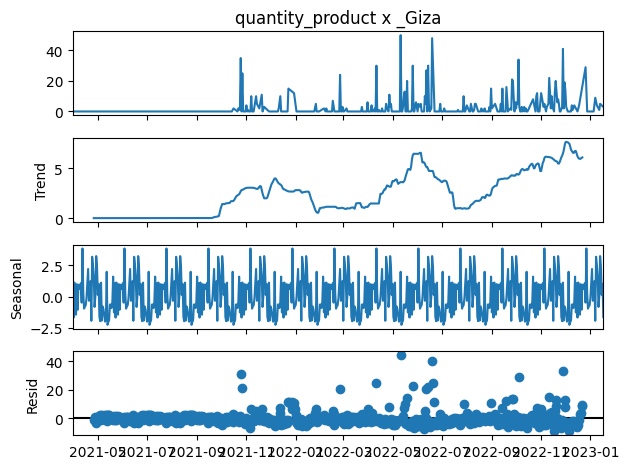

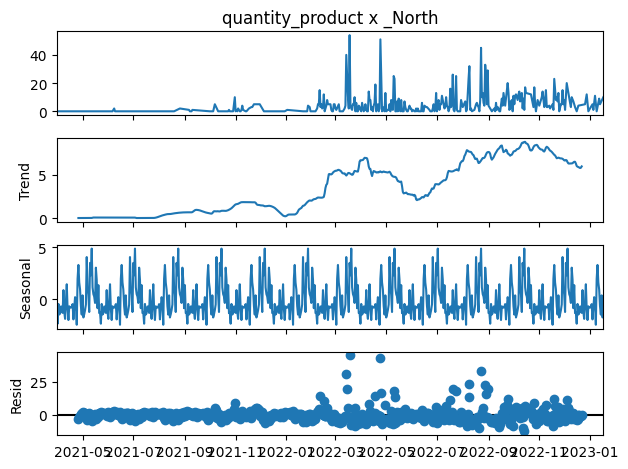

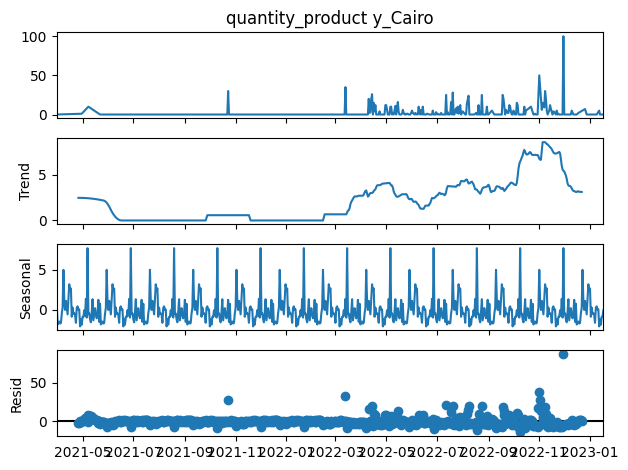

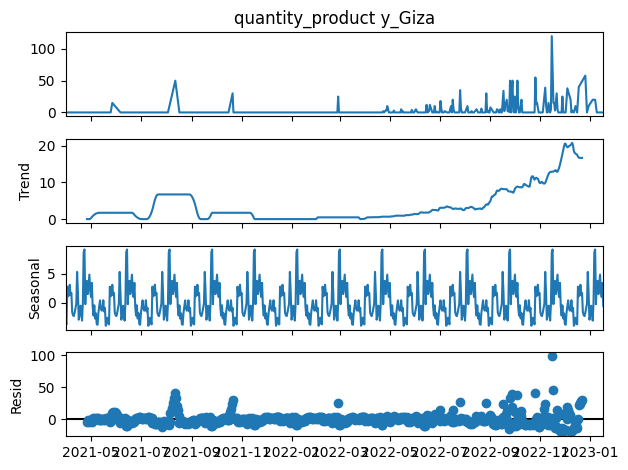

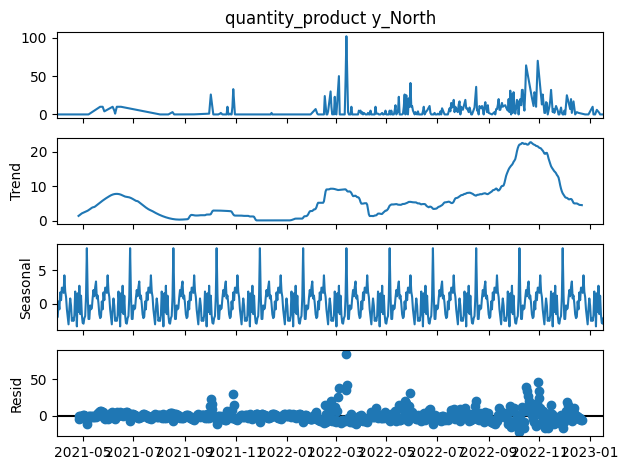

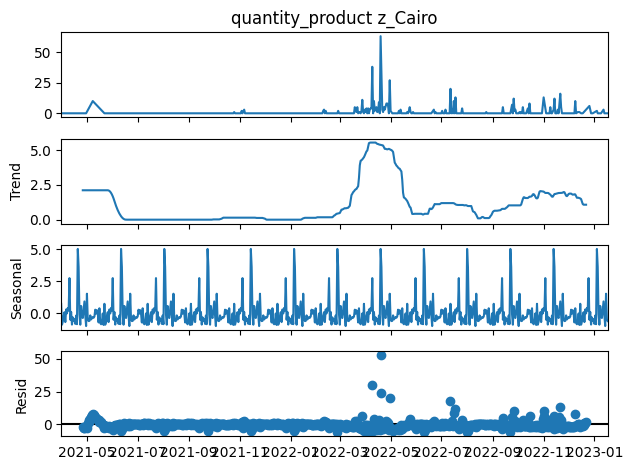

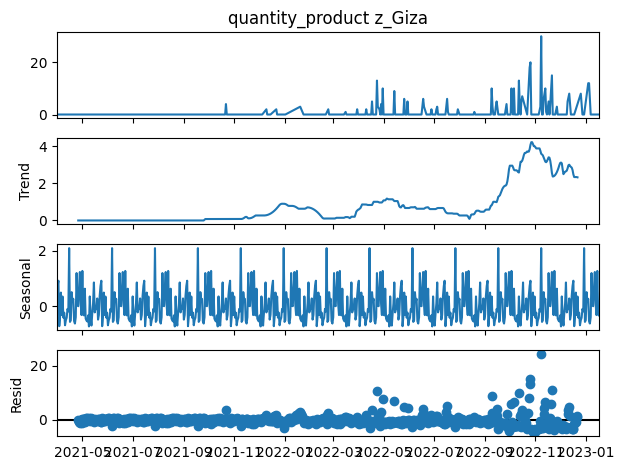

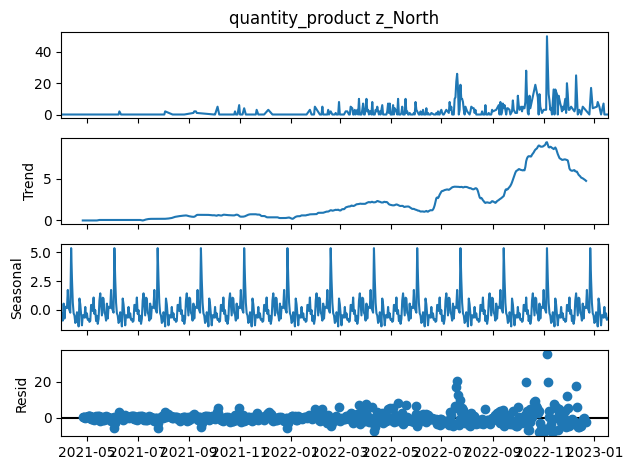

In [34]:
def decompose_time_series(series):
    decomposition = seasonal_decompose(series, model='additive', period=52)
    decomposition.plot()
    plt.show()

# Decompose the first column to visualize seasonality
for i in range (19 , 27 , 1) :
  decompose_time_series(pivot_df_resampled.iloc[:, i])


# **data is non stationary and have seasonal component .**

try SARIMAX model .


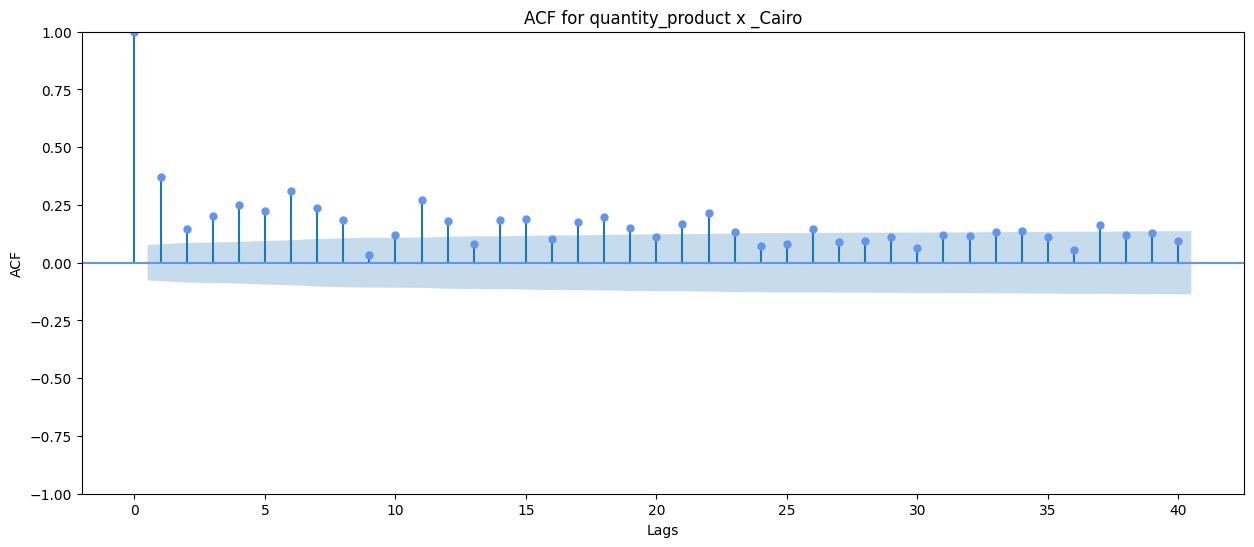

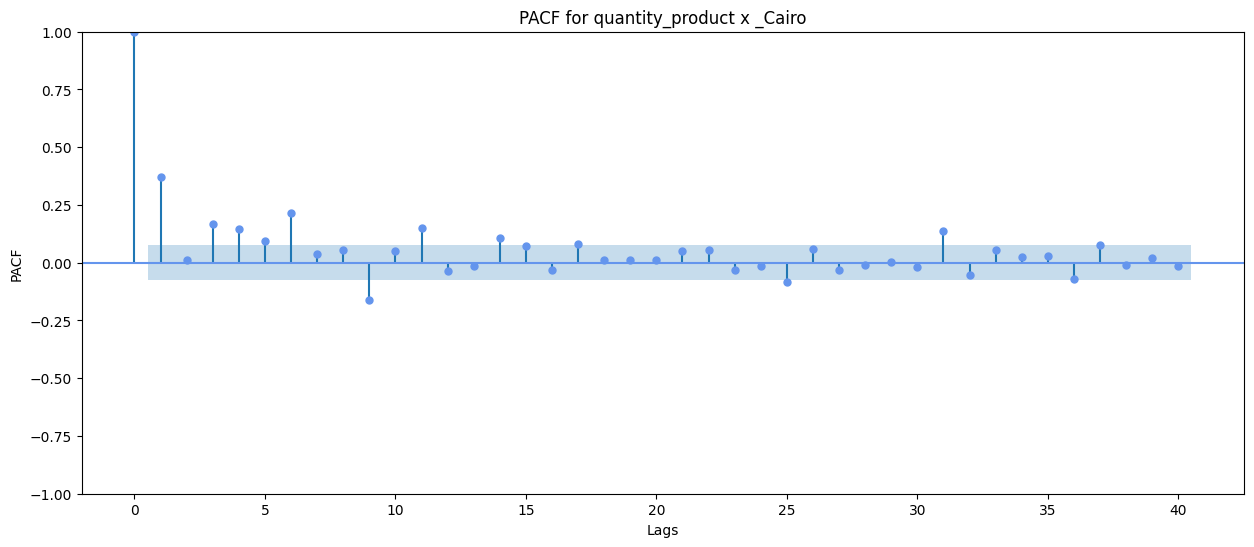

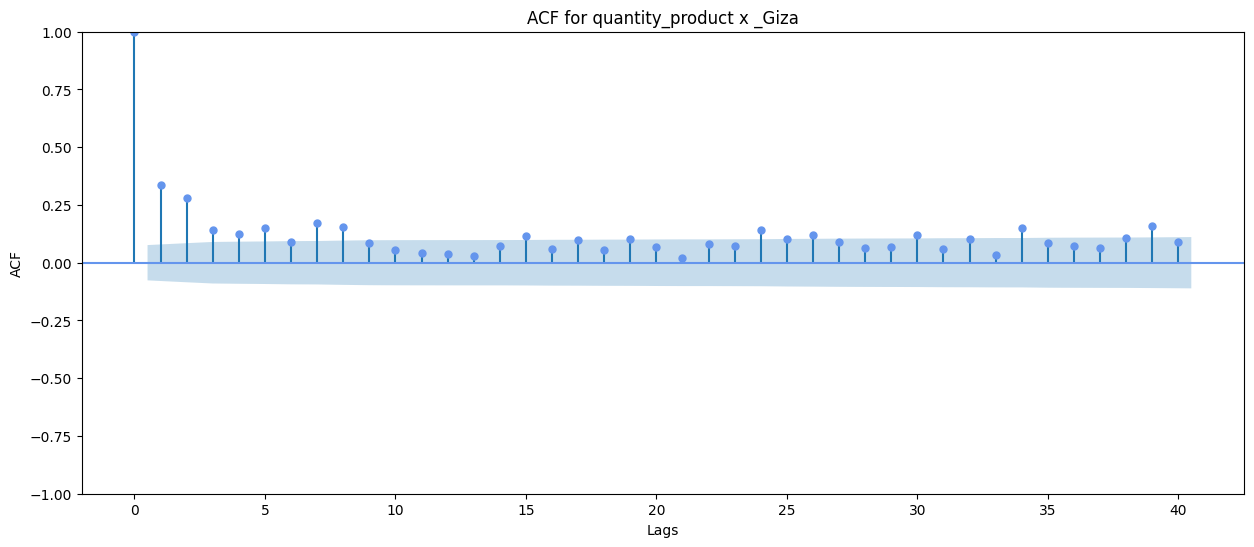

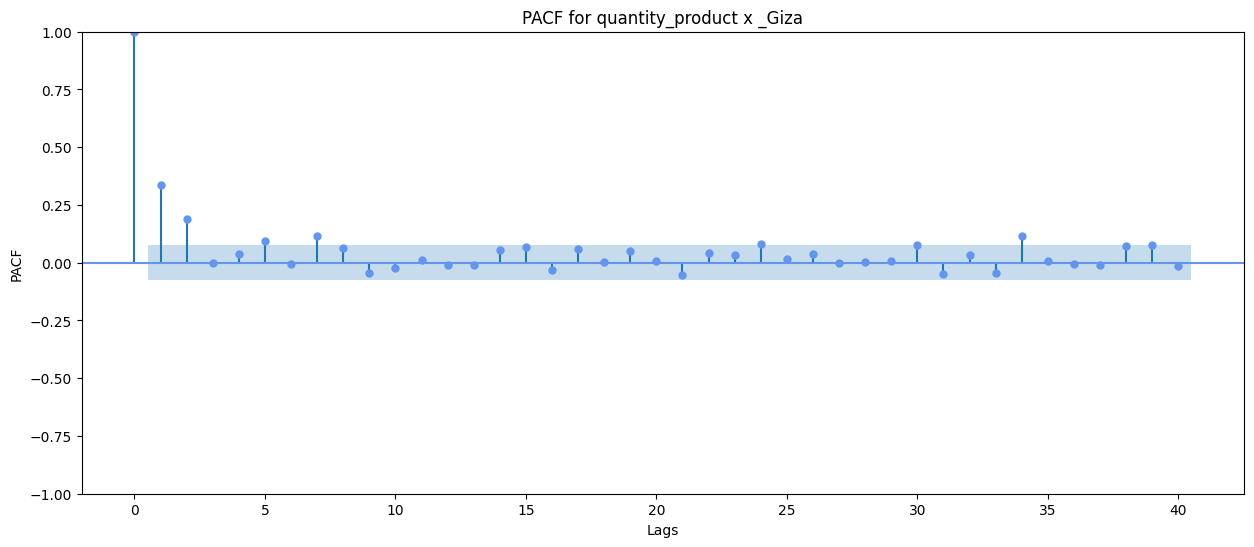

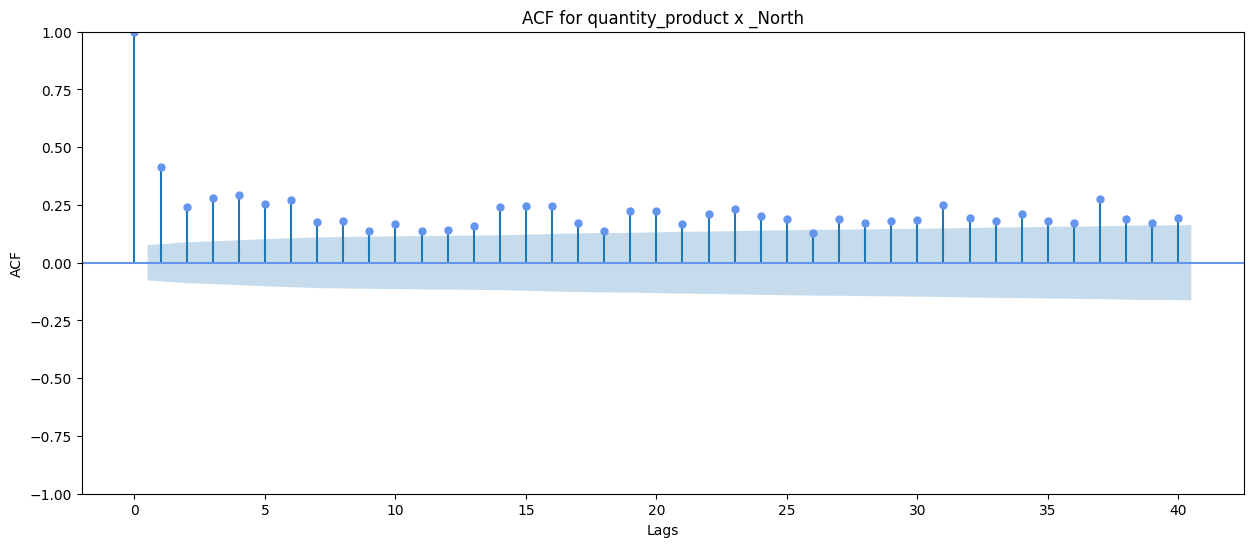

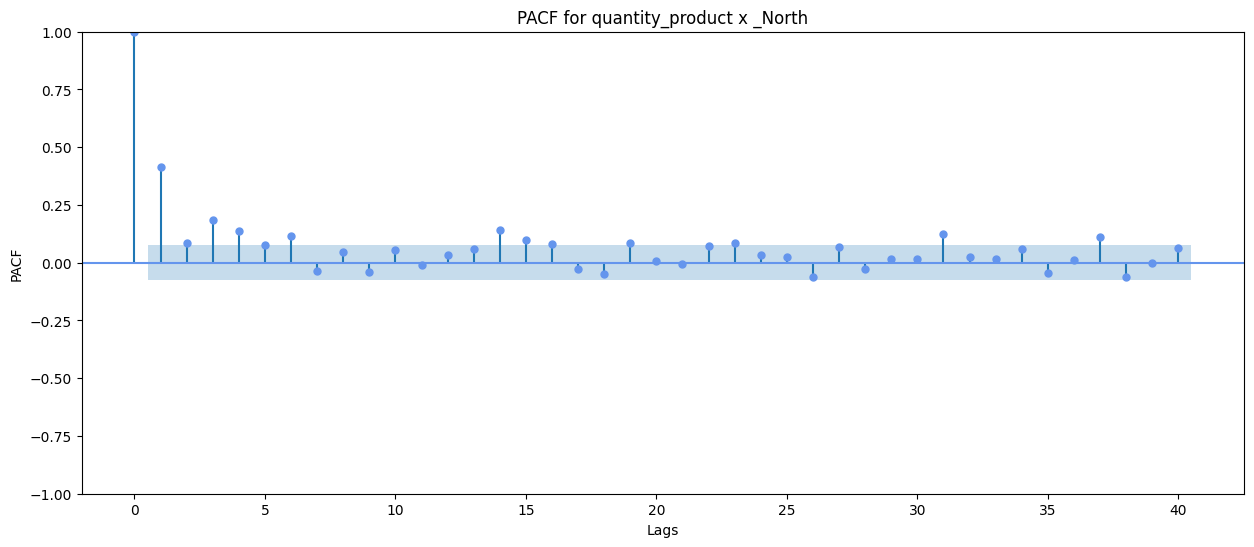

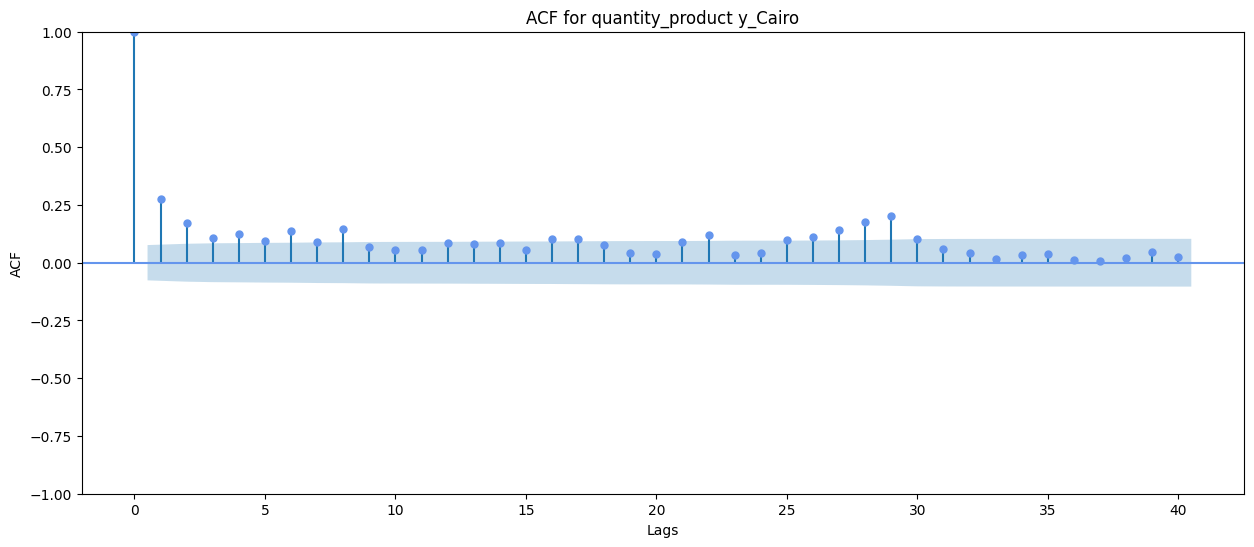

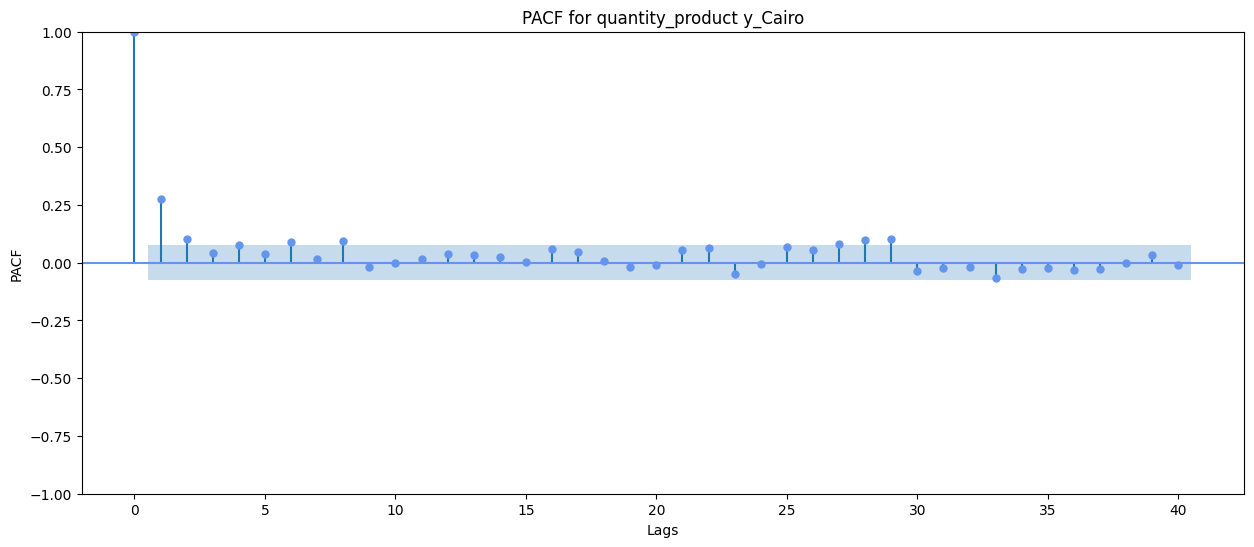

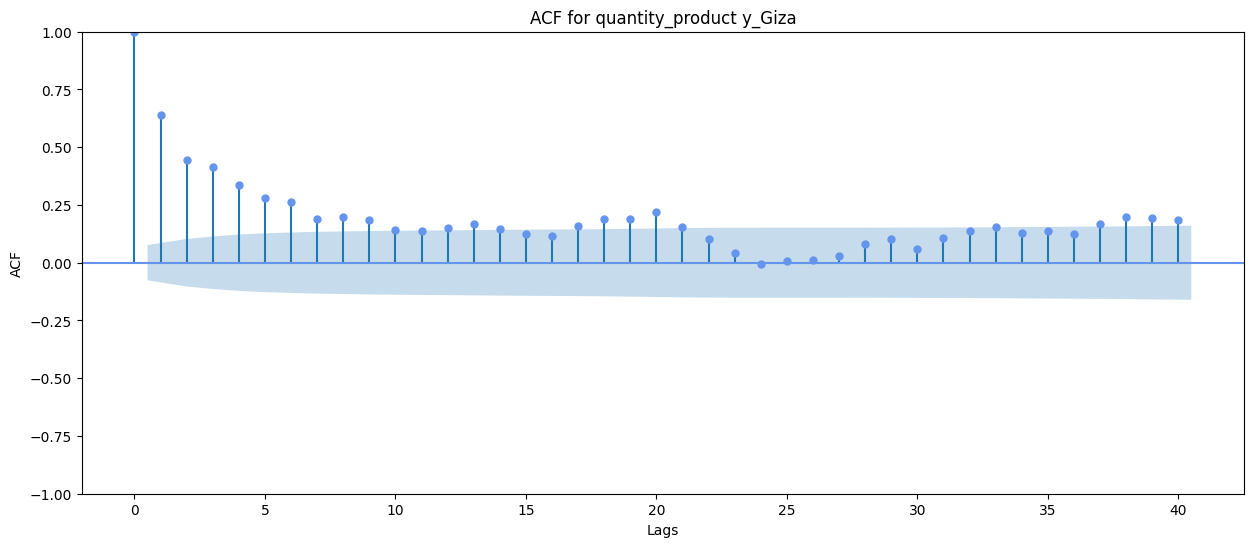

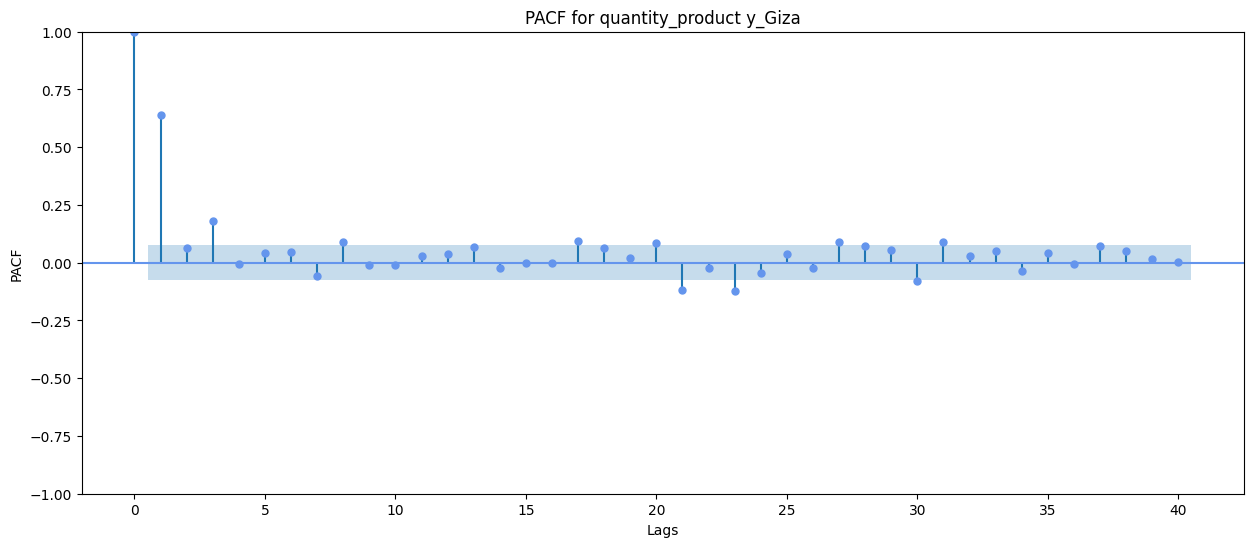

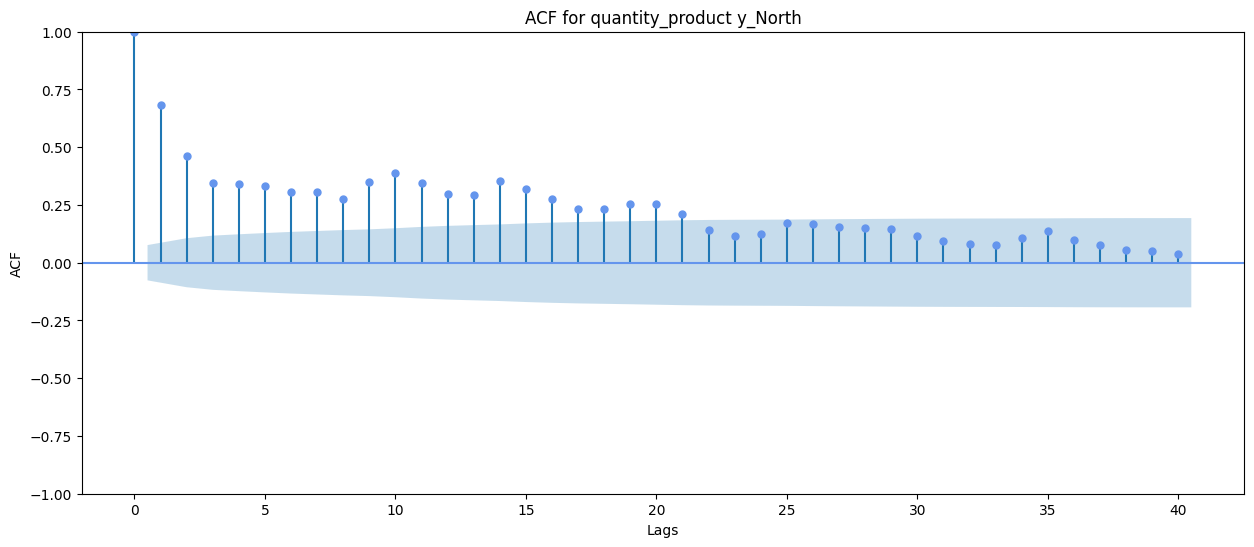

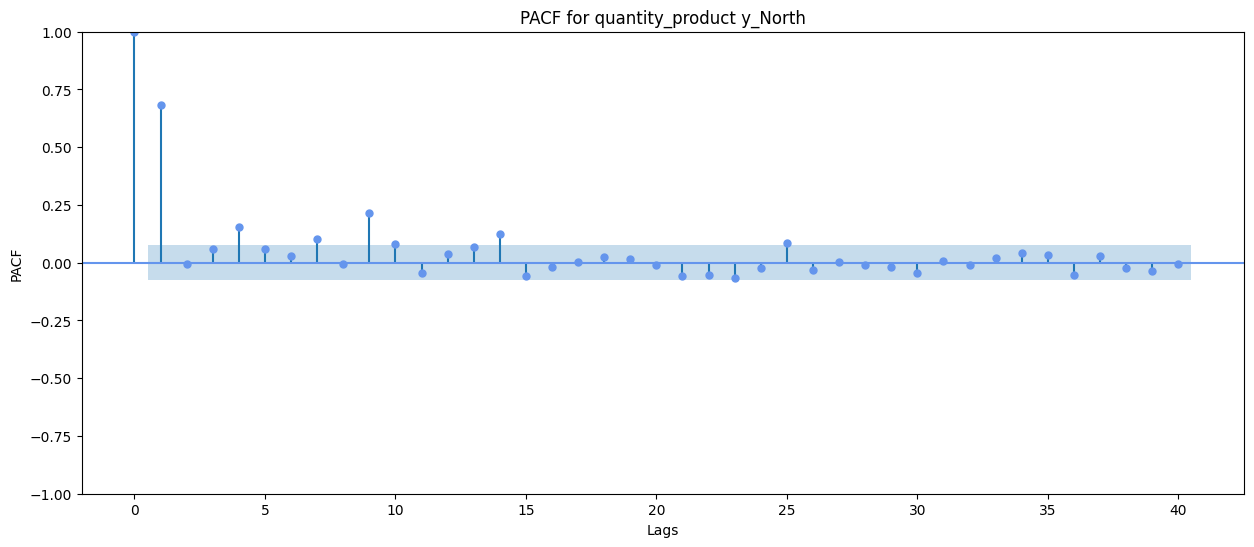

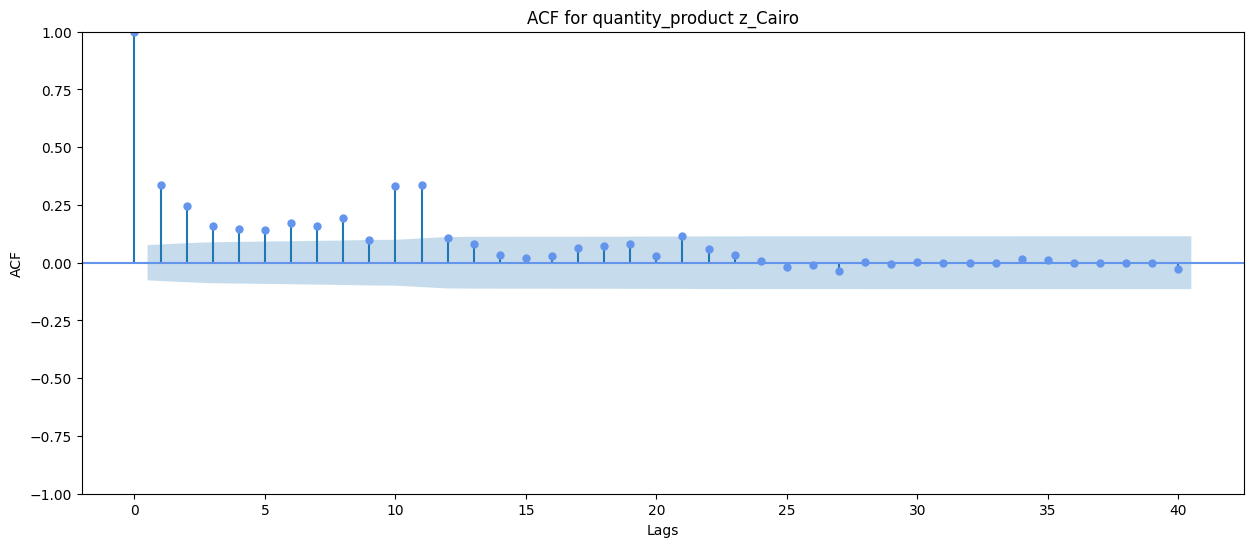

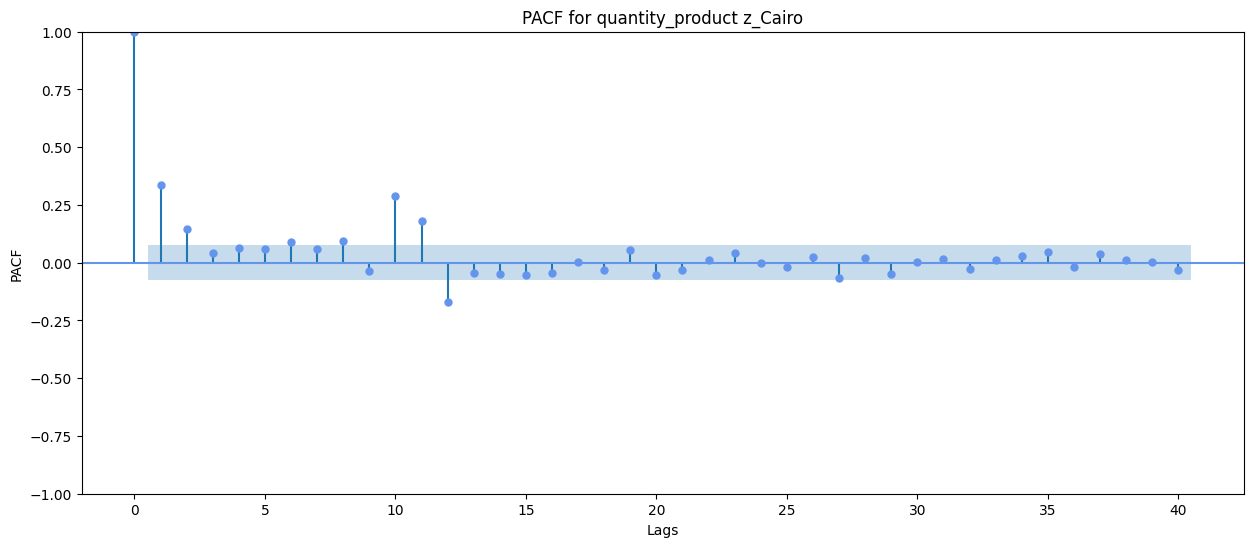

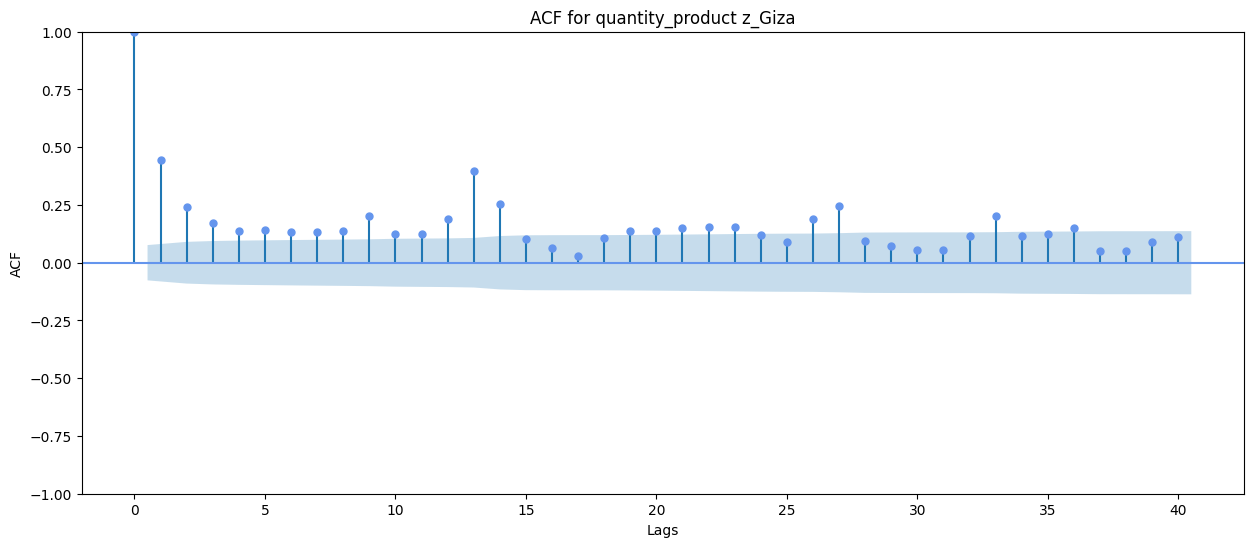

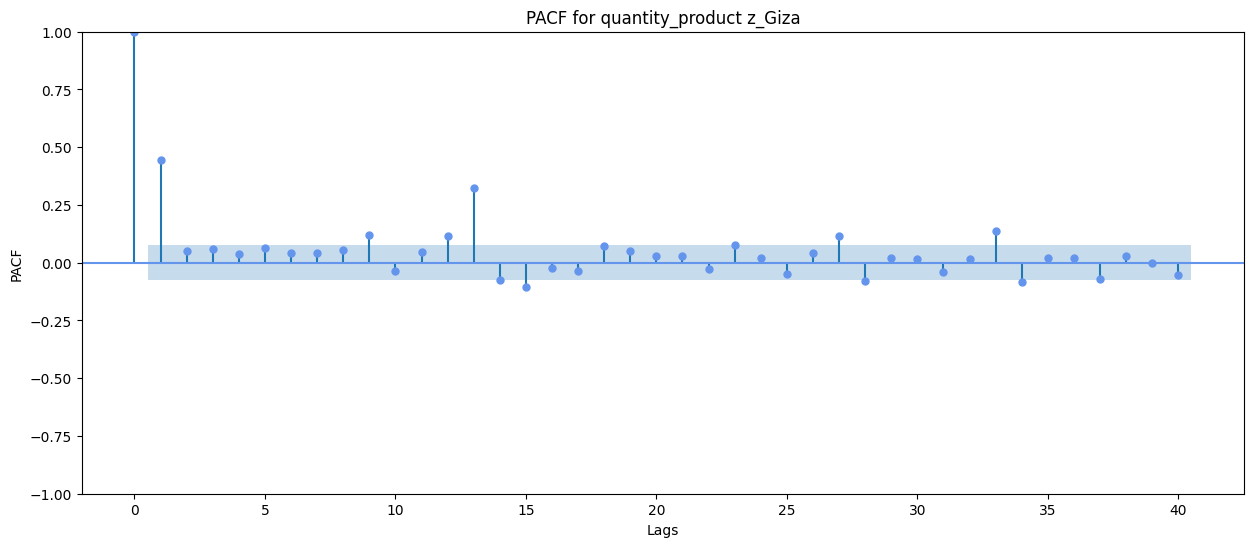

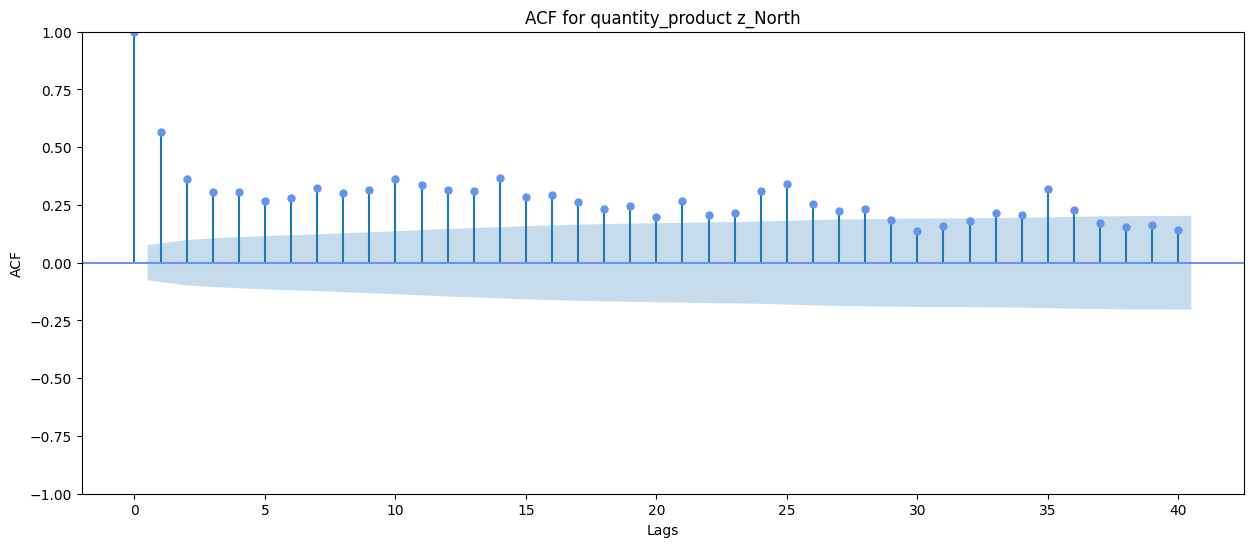

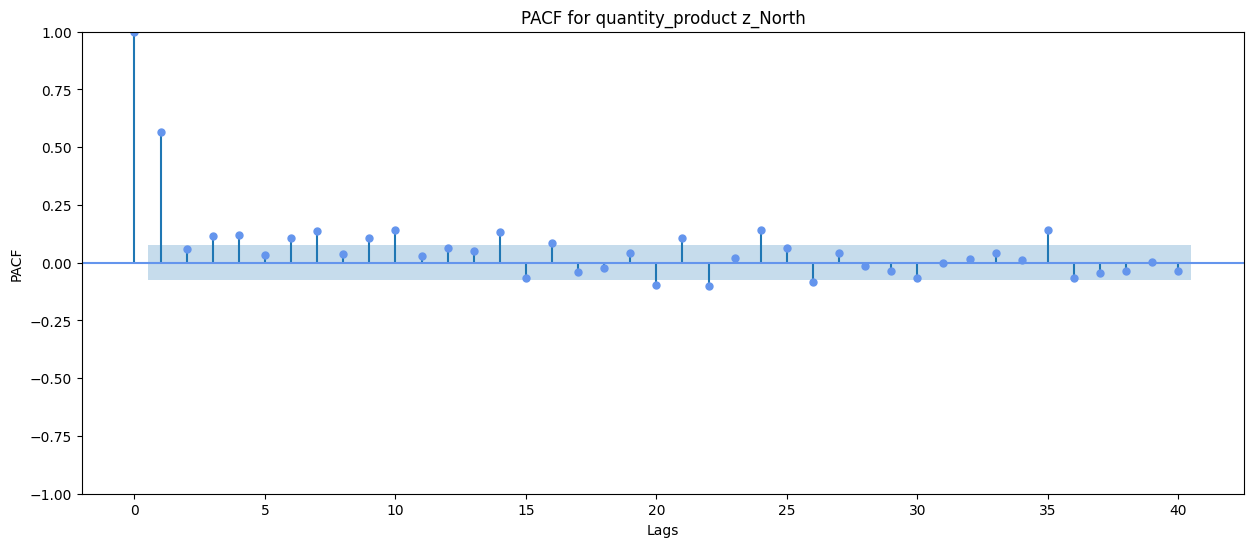

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Loop through your target columns and plot ACF and PACF
for col in out_cols:
    # Plot ACF
    plt.figure(figsize=(15, 6))
    plot_acf(pivot_df_resampled[col], lags=40, ax=plt.gca(), color='cornflowerblue')
    plt.title(f'ACF for {col}')
    plt.xlabel('Lags')
    plt.ylabel('ACF')
    plt.show()

    # Plot PACF
    plt.figure(figsize=(15, 6))
    plot_pacf(pivot_df_resampled[col], lags=40, ax=plt.gca(), color='cornflowerblue')
    plt.title(f'PACF for {col}')
    plt.xlabel('Lags')
    plt.ylabel('PACF')
    plt.show()


In [43]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Loop over each target column to fit a SARIMAX model
for col in out_cols:
    # Split the data into train and test sets
    train_size = int(len(pivot_df_resampled) * 0.8)  # 80% for training
    train, test = pivot_df_resampled[col][:train_size], pivot_df_resampled[col][train_size:]  # Split the data

    # Fit the SARIMAX model to the training set
    model = SARIMAX(train,
                    order=(1, 1,40),  # ARIMA parameters (p, d, q)
                    seasonal_order=(0, 0, 0,52),  # Seasonal ARIMA parameters (P, D, Q, S)
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    model_fit = model.fit(disp=False)

    # Print the results for the model fit
    print(f"Results for {col}:")
    print(model_fit.summary())

    # Forecast the future values based on the test period
    forecast = model_fit.get_forecast(steps=len(test))  # Forecasting for the length of the test set
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Plot the forecasted values against the actual test values
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Training data')  # Plot the historical training data
    plt.plot(test.index, test, label='Actual test data')  # Plot the actual test data
    plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')  # Plot the forecasted values
    plt.fill_between(forecast_mean.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)  # Plot confidence intervals
    plt.legend()
    plt.title(f'Out-of-Sample Forecasting for {col}')
    plt.show()


KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best order (p, d, q): (1, 1, 19)
Best AIC: 2196.302437798423


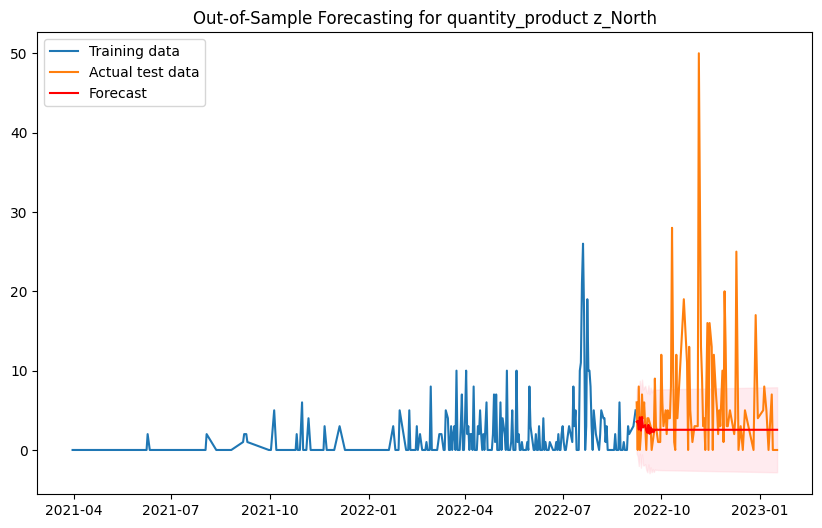

In [41]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define ranges for p, d, q
p_values = range(0,20)  # Try values from 0 to 5 for p
d_values = range(1, 2)  # Usually 0 or 1 for differencing
q_values = range(0,20)  # Try values from 0 to 5 for q

# Create a grid of all possible (p, d, q) combinations
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

best_aic = float('inf')
best_order = None
best_seasonal_order = (0, 0, 0, 52)  # Assuming yearly seasonality (S=12 for monthly data)
best_model = None

# Loop through all possible combinations of (p, d, q)
for order in pdq_combinations:
    try:
        # Split the data into train and test sets
        train_size = int(len(pivot_df_resampled) * 0.8)  # 80% for training
        train, test = pivot_df_resampled[col][:train_size], pivot_df_resampled[col][train_size:]  # Split the data

        # Fit the SARIMAX model with the current (p, d, q)
        model = SARIMAX(train,
                        order=order,  # ARIMA parameters (p, d, q)
                        seasonal_order=best_seasonal_order,  # Seasonal order (fixed here)
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=False)

        # Check AIC value for the current model
        aic = model_fit.aic

        # If this model has a lower AIC, update the best model
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = model_fit

    except Exception as e:
        print(f"Skipping {order} due to error: {e}")
        continue

# Output the best (p, d, q) combination and its corresponding AIC
print(f"Best order (p, d, q): {best_order}")
print(f"Best AIC: {best_aic}")

# Plot the forecast using the best model
forecast = best_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the forecasted values against the actual test values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training data')  # Plot the historical training data
plt.plot(test.index, test, label='Actual test data')  # Plot the actual test data
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')  # Plot the forecasted values
plt.fill_between(forecast_mean.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)  # Plot confidence intervals
plt.legend()
plt.title(f'Out-of-Sample Forecasting for {col}')
plt.show()


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate performance metrics
mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE
mae = mean_absolute_error(test, forecast_mean)

# Print performance metrics
print(f"Performance Metrics for {col}:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

In [ ]:
from sklearn.metrics import mean_squared_error
forecast = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error (MSE): {mse}")

In [ ]:
print("AIC:", model_fit.aic)
print("BIC:", model_fit.bic)


AIC: 281.16336592727885
BIC: 301.3998231057231


-----------------------------------------------------------------------------------------------------------------------------

In [44]:
# multivariate lstm example
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import TimeDistributed,RepeatVector

In [45]:
y = pivot_df_resampled[out_cols]
X = pivot_df_resampled.drop(out_cols, axis=1)

In [46]:
def split_sequences_multi_output(data, n_steps, forecast_horizon, n_features_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        out_end_ix = end_ix + forecast_horizon - 1
        if out_end_ix > len(data) - 1:
            break
        seq_x = data[i:end_ix, :-n_features_out]  # Exclude future output features (data leakage)
        seq_y = data[end_ix:out_end_ix + 1, -n_features_out:]  # Collect 10-day future outputs
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [47]:
n_steps = 40
n_features_out=9
forecast_horizon = 10  # Predict 10 days ahead

In [48]:
dataset = hstack((X,y))

# convert into input/output
X, y = split_sequences_multi_output(dataset, n_steps, forecast_horizon, n_features_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
n_output_features = y.shape[2]  # Number of output features (9)

In [49]:
import datetime

# Define your reference date (e.g., 2020-01-01)
reference_date = np.datetime64('2021-03-31')

# Convert datetime.date to number of days since the reference date
def convert_dates_to_days_since_reference(data):
    # Convert to NumPy datetime64 and subtract reference_date to get the timedelta
    return (np.datetime64(data) - reference_date).astype('timedelta64[D]').astype(int)

# Apply this conversion to the first column (which contains datetime.date)
for i in range(X.shape[0]):  # Iterate over each sample
    for j in range(X.shape[1]):  # Iterate over each time step
        if isinstance(X[i, j, 0], datetime.date):  # If the element is a date object
            X[i, j, 0] = convert_dates_to_days_since_reference(X[i, j, 0])

# After converting, X will have numerical days values in place of the dates


In [50]:
X

array([[[102.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 98.6       ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 95.2       ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,  39.375     ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,  45.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,  41.78571429,
           0.        ,   0.        ]],

       [[ 98.6       ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 95.2       ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 91.8       ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,


In [51]:
X = X.astype('float32')
y = y.astype('float32')

In [52]:
from sklearn.model_selection import train_test_split
# Assuming X and y are your input and output arrays respectively
test_size = 0.2  # 20% of the data for testing
X_test= X[-10:]
y_test= y[-10:]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (487, 40, 27), y_train shape: (487, 10, 9)
X_test shape: (10, 40, 27), y_test shape: (10, 10, 9)


In [53]:
print("X shape:", X.shape)  # Expected: (num_samples, n_steps, n_features)
print("y shape:", y.shape)  # Expected: (num_samples, 10)


X shape: (609, 40, 27)
y shape: (609, 10, 9)


In [92]:
model = Sequential()
model.add(LSTM(40, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.7))
model.add(Dense(n_output_features * forecast_horizon))  # Output layer adjusted for multi-feature output
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 40)                  │          10,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 90)                  │           3,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,570 (56.91 KB)

 Trainable params: 14,570 (56.91 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features)))
model.add(RepeatVector(n_output_features))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

NameError: name 'n_steps_in' is not defined

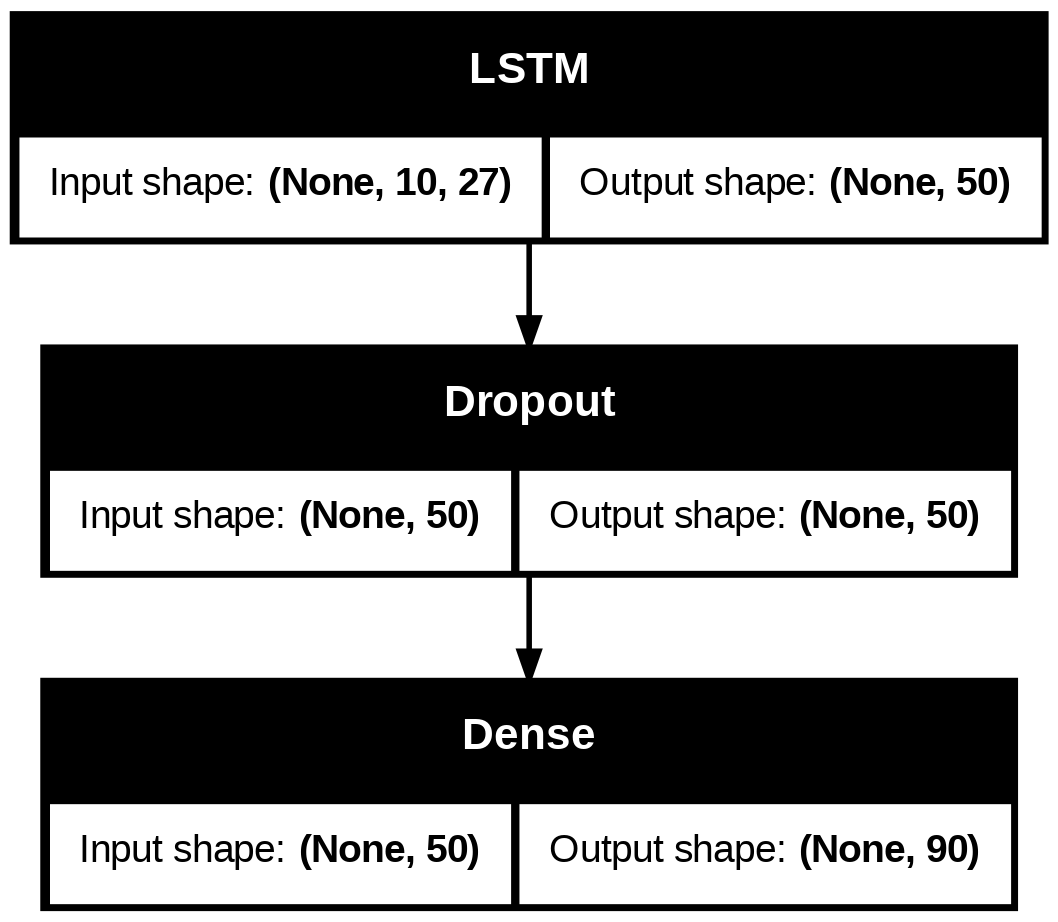

In [176]:
plot_model(model, show_shapes=True)

In [93]:

# Train the model
# Train the model with validation data
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 32478.7285 - val_loss: 2976.8169
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8313.5254 - val_loss: 1378.4620
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2955.7202 - val_loss: 1228.5370
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4810.4600 - val_loss: 2537.4004
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3700.9011 - val_loss: 726.7341
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2281.0088 - val_loss: 915.2239
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4242.0405 - val_loss: 2668.9070
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5820.2856 - val_loss: 3018.5667
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4076.0896 - val_loss: 2560.0051
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4226.8208 - val_loss: 1529.5909
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3404.2007 - val_loss: 1749.2031
Epoch 

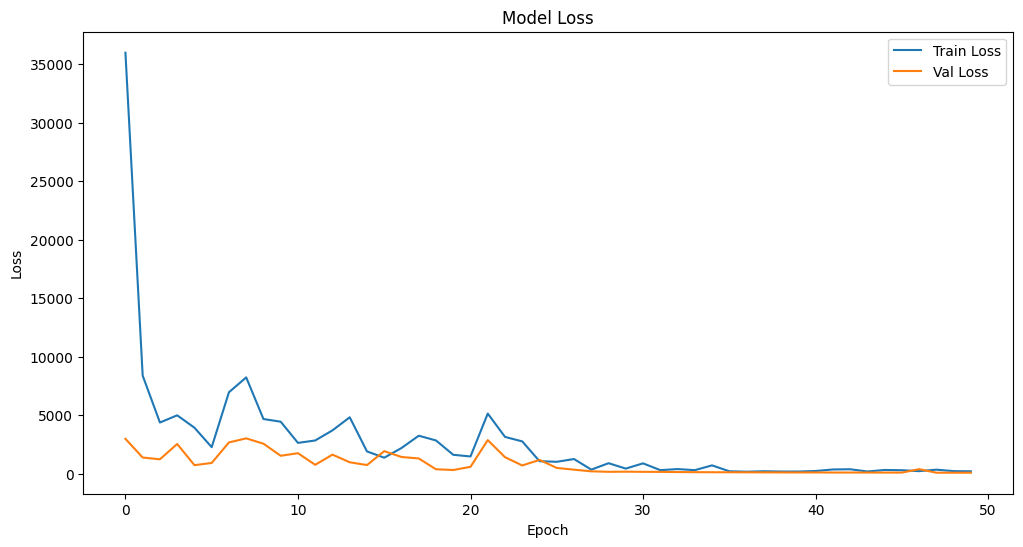

In [94]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot additional metrics if added
if 'mae' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


In [95]:
  # Making a prediction
yhat = model.predict(X_test, verbose=0)  # Predict future sequences
yhat = yhat.reshape(yhat.shape[0], forecast_horizon, n_output_features)
y = y.astype('int')
yhat- y_test

array([[[-1.26549777e+00,  6.28985720e+00,  1.34282127e+01,
          5.64226284e+00,  5.17025622e+00,  9.04066539e+00,
          1.12111978e-01, -6.67287632e+00,  1.32799107e+00],
        [ 8.36116559e+00, -2.26734447e+00,  7.82752613e+00,
         -4.34103832e+00,  5.21428465e+00,  1.23321591e+01,
          1.28159668e+01,  2.07810483e+00,  5.50901433e+00],
        [ 2.57811251e+00,  1.38940774e+00,  8.90622692e+00,
          1.77375186e+00,  1.60936797e+00,  9.23117395e+00,
         -1.74046092e+00,  1.99740565e+00, -2.99347520e+00],
        [ 7.12049966e+00,  4.61522461e+00, -3.78982679e+00,
          8.46234447e+00,  8.38331198e-01,  1.53329778e+01,
         -3.81207717e+00,  7.89758605e+00,  6.33327685e+00],
        [-4.96643320e-01,  1.28705659e+01,  1.11927671e+01,
          5.93551031e+00,  5.07275546e+00, -6.63665718e+00,
          2.82696238e+00,  3.82981327e+00, -4.29887794e+00],
        [ 8.29543480e+00, -1.18527400e+01, -1.43589836e+00,
          9.84740926e-01,  1.889131

In [70]:
yhat.shape

(10, 10, 9)

In [71]:
y_test.shape

(10, 10, 9)

In [72]:
yhat = yhat.astype('int32')
y_test = y_test.astype('int32')



Combined shape: (10, 10, 18)
Mean Squared Error: 0.1654259913172198
ROOt Mean Squared Error: 0.4067259412887501
Mean Absolute Error: 0.3327316207384023


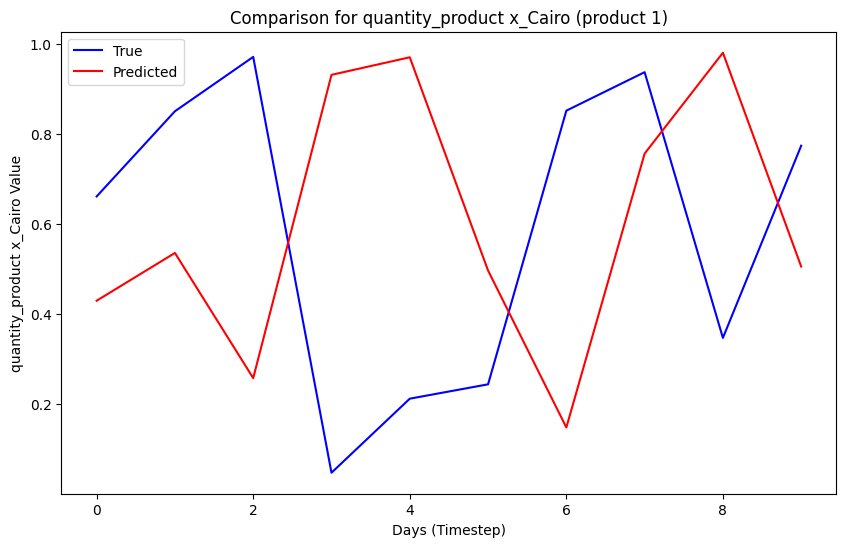

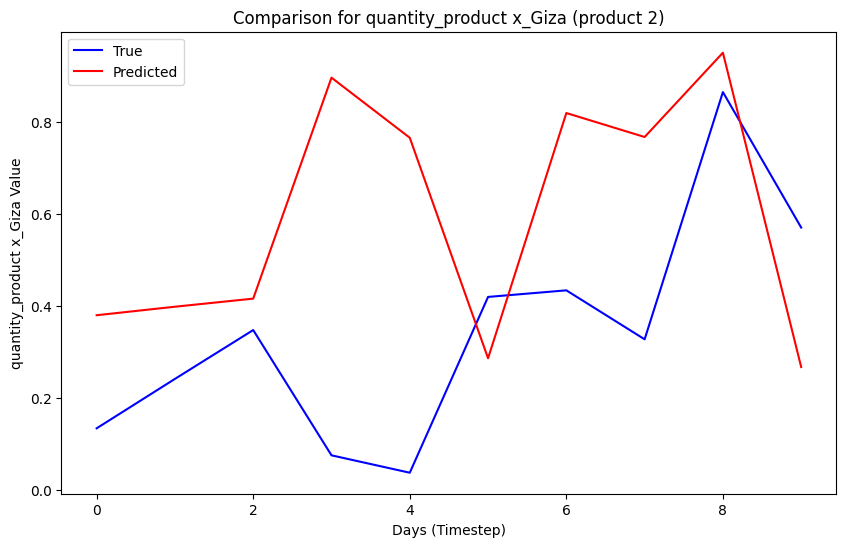

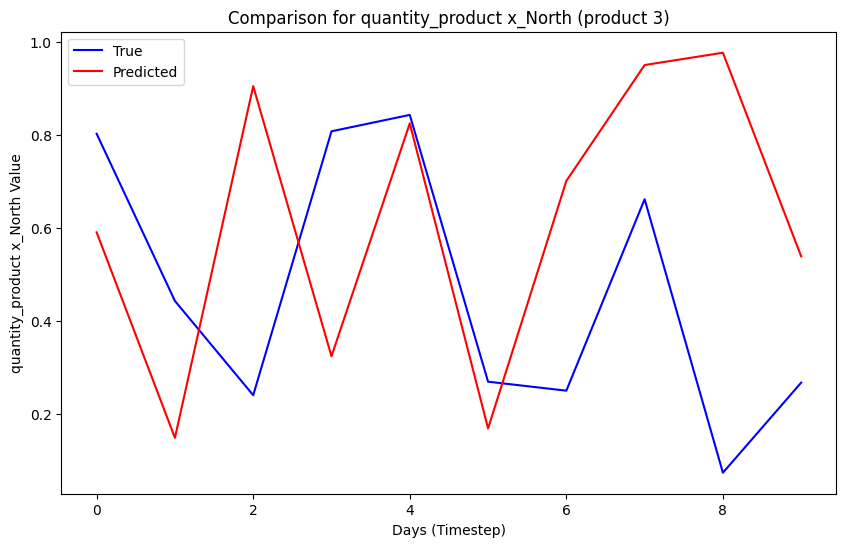

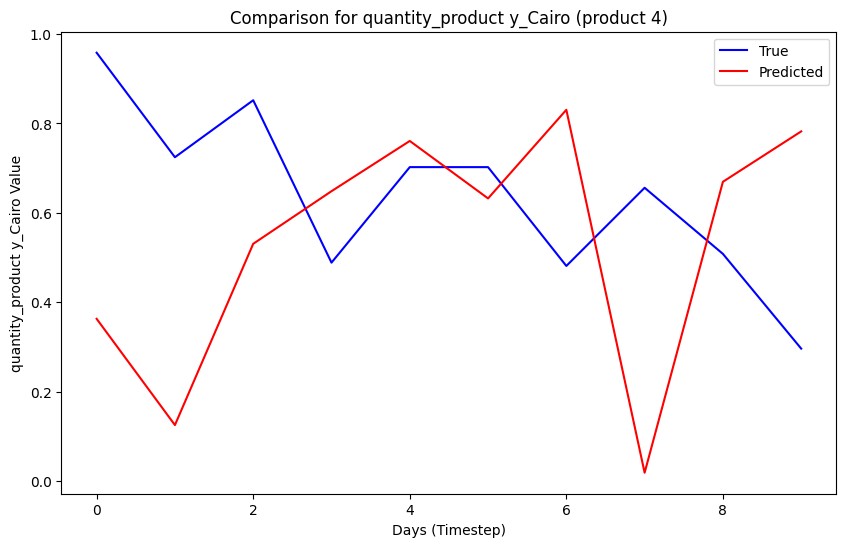

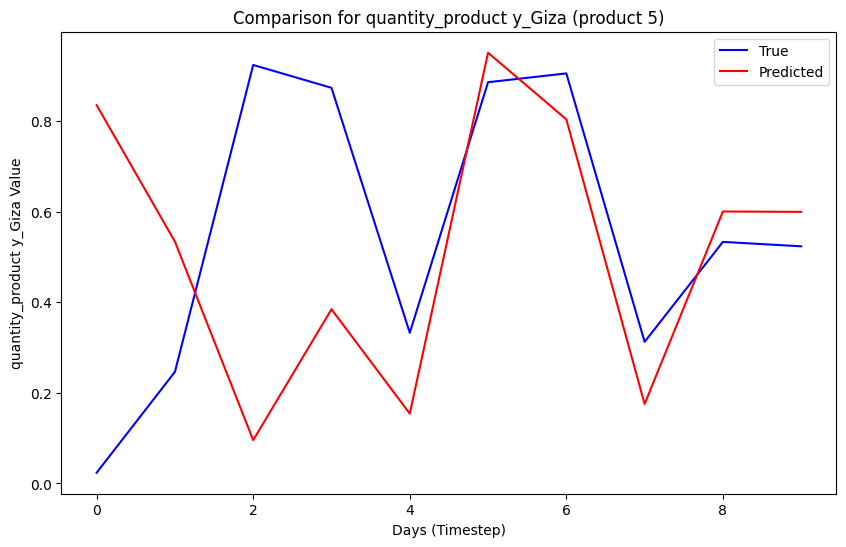

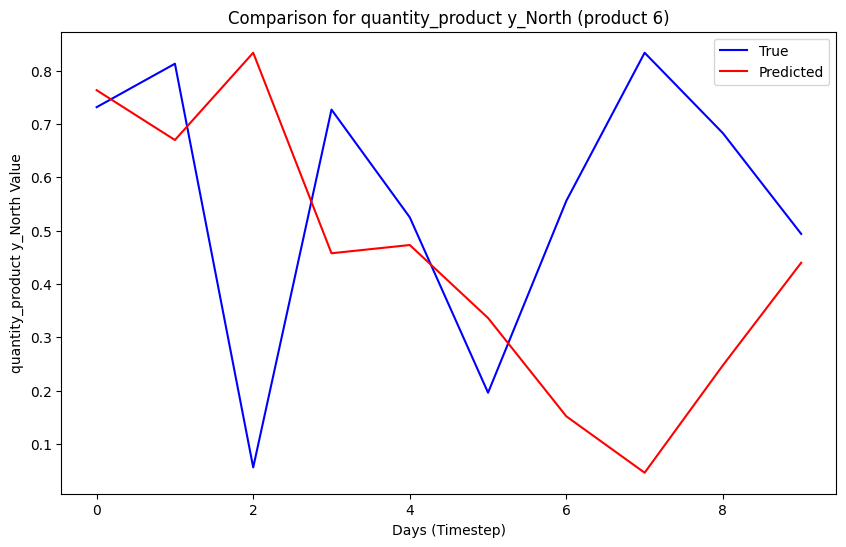

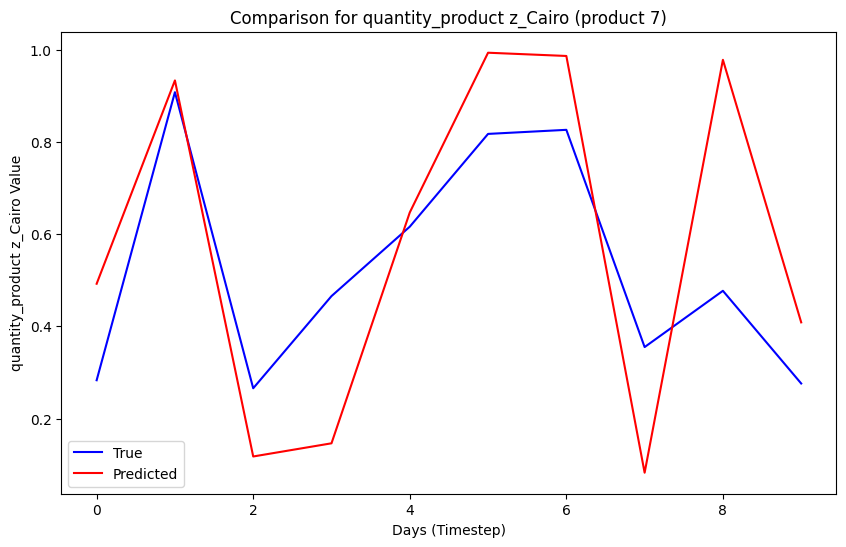

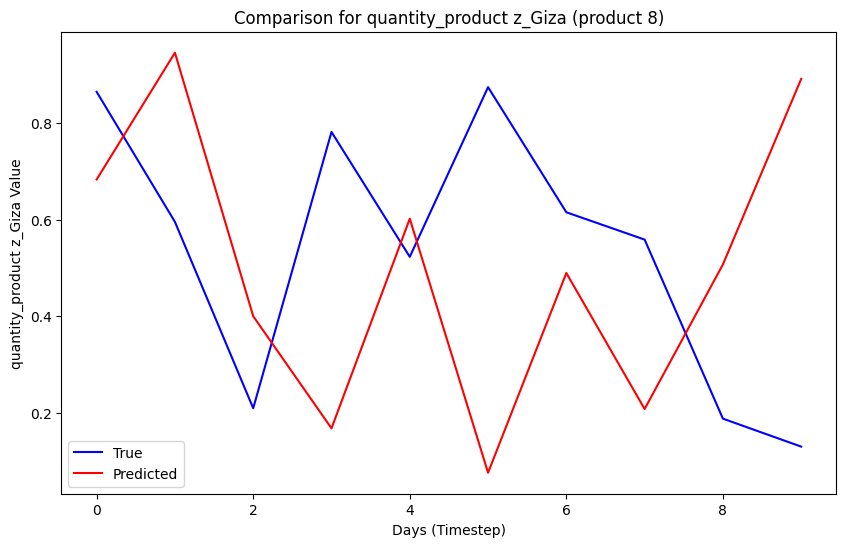

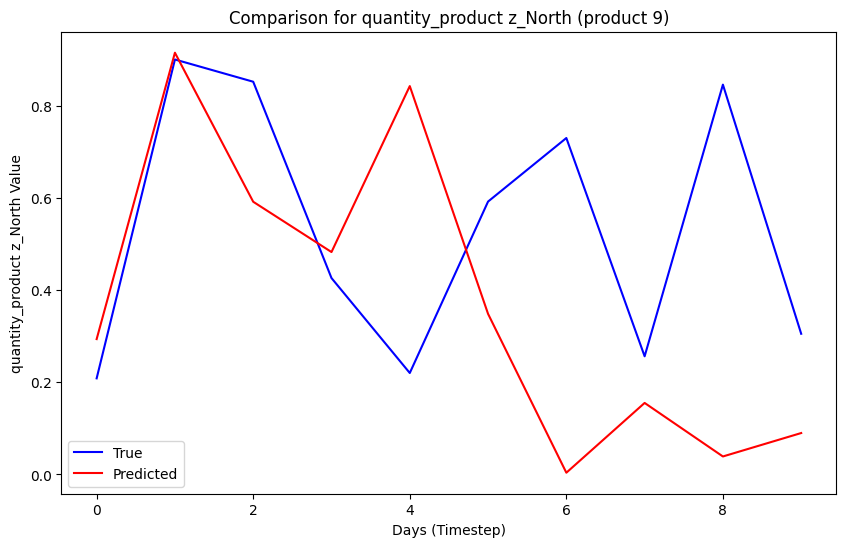

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Sample shape: (samples, timesteps, features)
y_test = np.random.rand(10, 10, 9)  # Actual values for 10 samples, 10 days, 9 products
y_pred = np.random.rand(10, 10, 9)  # Predicted values for 10 samples, 10 days, 9 products

# List of product names
product_names = [
    'quantity_product x_Cairo',
    'quantity_product x_Giza',
    'quantity_product x_North',
    'quantity_product y_Cairo',
    'quantity_product y_Giza',
    'quantity_product y_North',
    'quantity_product z_Cairo',
    'quantity_product z_Giza',
    'quantity_product z_North'

]

# 1. Combine y_test and y_pred for comparison (along the feature axis)
combined = np.concatenate([y_test, y_pred], axis=-1)
print(f"Combined shape: {combined.shape}")

# 2. Compute Mean Squared Error (MSE) for all samples, timesteps, and products
mse = mean_squared_error(y_test.reshape(-1, y_test.shape[-1]),
                         y_pred.reshape(-1, y_pred.shape[-1]), multioutput='uniform_average')
print(f"Mean Squared Error: {mse}")
print(f"ROOt Mean Squared Error: {mse**0.5}")

# 3. Compute Mean Absolute Error (MAE) for all samples, timesteps, and products
mae = mean_absolute_error(y_test.reshape(-1, y_test.shape[-1]),
                          y_pred.reshape(-1, y_pred.shape[-1]), multioutput='uniform_average')
print(f"Mean Absolute Error: {mae}")

# 4. Visualize the comparison for each product over time (for one sample, for simplicity)
sample_idx = 0  # You can loop through other samples if needed
timesteps = y_test.shape[1]
products = y_test.shape[2]

for product_idx in range(products):
    plt.figure(figsize=(10, 6))

    # Plot True values
    plt.plot(range(timesteps), y_test[sample_idx, :, product_idx], label='True', color='blue')

    # Plot Predicted values
    plt.plot(range(timesteps), y_pred[sample_idx, :, product_idx], label='Predicted', color='red')

    plt.title(f"Comparison for {product_names[product_idx]} (product {product_idx + 1})")
    plt.xlabel('Days (Timestep)')
    plt.ylabel(f'{product_names[product_idx]} Value')
    plt.legend()
    plt.show()
